# GROUP 7 - Analytics and Applications

# Task 1: Data Collection and Preparation

In [1499]:
import numpy as np 
import matplotlib.pyplot as plt     
import pandas as pd 
import seaborn as sns
import ast

from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.neural_network import MLPRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, silhouette_score
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, PolynomialFeatures
from sklearn.tree import DecisionTreeRegressor, export_text, plot_tree
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.mixture import GaussianMixture
from sklearn.inspection import permutation_importance

import matplotlib.pyplot as plt

In [1500]:
df = pd.read_csv("./Data/charging_sessions.csv")
df.head()

,Unnamed: 0,id,connectionTime,disconnectTime,doneChargingTime,kWhDelivered,sessionID,siteID,spaceID,stationID,timezone,userID,userInputs
0,0,5e23b149f9af8b5fe4b973cf,2020-01-02 13:08:54+00:00,2020-01-02 19:11:15+00:00,2020-01-02 17:31:35+00:00,25.016,1_1_179_810_2020-01-02 13:08:53.870034,1,AG-3F30,1-1-179-810,America/Los_Angeles,194.0,"[{'WhPerMile': 250, 'kWhRequested': 25.0, 'mil..."
1,1,5e23b149f9af8b5fe4b973d0,2020-01-02 13:36:50+00:00,2020-01-02 22:38:21+00:00,2020-01-02 20:18:05+00:00,33.097,1_1_193_825_2020-01-02 13:36:49.599853,1,AG-1F01,1-1-193-825,America/Los_Angeles,4275.0,"[{'WhPerMile': 280, 'kWhRequested': 70.0, 'mil..."
2,2,5e23b149f9af8b5fe4b973d1,2020-01-02 13:56:35+00:00,2020-01-03 00:39:22+00:00,2020-01-02 16:35:06+00:00,6.521,1_1_193_829_2020-01-02 13:56:35.214993,1,AG-1F03,1-1-193-829,America/Los_Angeles,344.0,"[{'WhPerMile': 400, 'kWhRequested': 8.0, 'mile..."
3,3,5e23b149f9af8b5fe4b973d2,2020-01-02 13:59:58+00:00,2020-01-02 16:38:39+00:00,2020-01-02 15:18:45+00:00,2.355,1_1_193_820_2020-01-02 13:59:58.309319,1,AG-1F04,1-1-193-820,America/Los_Angeles,1117.0,"[{'WhPerMile': 400, 'kWhRequested': 8.0, 'mile..."
4,4,5e23b149f9af8b5fe4b973d3,2020-01-02 14:00:01+00:00,2020-01-02 22:08:40+00:00,2020-01-02 18:17:30+00:00,13.375,1_1_193_819_2020-01-02 14:00:00.779967,1,AG-1F06,1-1-193-819,America/Los_Angeles,334.0,"[{'WhPerMile': 400, 'kWhRequested': 16.0, 'mil..."


In [1501]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 66450 entries, 0 to 66449
Data columns (total 13 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Unnamed: 0        66450 non-null  int64  
 1   id                66450 non-null  object 
 2   connectionTime    66450 non-null  object 
 3   disconnectTime    66450 non-null  object 
 4   doneChargingTime  62362 non-null  object 
 5   kWhDelivered      66450 non-null  float64
 6   sessionID         66450 non-null  object 
 7   siteID            66450 non-null  int64  
 8   spaceID           66450 non-null  object 
 9   stationID         66450 non-null  object 
 10  timezone          66450 non-null  object 
 11  userID            49187 non-null  float64
 12  userInputs        49187 non-null  object 
dtypes: float64(2), int64(2), object(9)
memory usage: 6.6+ MB


In [1502]:
print(df.isnull().sum())

Unnamed: 0              0
id                      0
connectionTime          0
disconnectTime          0
doneChargingTime     4088
kWhDelivered            0
sessionID               0
siteID                  0
spaceID                 0
stationID               0
timezone                0
userID              17263
userInputs          17263
dtype: int64


Finding: The columns doneChargingTime, userID, and userInputs have missing values.

In [1503]:
# Check for duplicates
print(df.duplicated().sum())

0


Finding: There are no duplicates

In [1504]:
# Check for invalid values
print(df[df['kWhDelivered'] < 0]),       

Empty DataFrame
Columns: [Unnamed: 0, id, connectionTime, disconnectTime, doneChargingTime, kWhDelivered, sessionID, siteID, spaceID, stationID, timezone, userID, userInputs]
Index: []


(None,)

Finding: There are no values with kWhDelivered < 0

# Data Cleaning


### Remove the column "Unnamed: 0" 
The column has 66450 empty values. This is equivalent to the amount of rows of the dataset, therefore it does not provide any value and can be removed. 

In [1505]:
df.drop(columns=['Unnamed: 0'], inplace=True)

### Replace "userID" na values with -1
There are 17263 data points with userID = na. Since this is a significant amount, removing the affected rows is not an option. 
To allow for further analysis in the upcoming milestones, it therefore makes sense to use a placeholder value.

In [1506]:
df.fillna({'userID': -1}, inplace=True)

### Remove "doneChargingTime" na values 
There are 4088 data points with doneChargingTime = na. 
Interpolation is not an option at this point, since it is very difficult to interpolate values for a metric that is dependent from connectionTime. By trying to estimate the doneChargingTime for missing entries based on the connectionTime of this entry and the average time of other loading processes, we could manipulate the dataset, because the battery could have different states of charge at the start of charging.

In [1507]:
df.dropna(subset=['doneChargingTime'], inplace=True)

### Remove the column "timezone"
Every timezone is set to "America/Los_Angeles", therefore it does not provide any value for further analysis and can be removed. 

In [1508]:
df.drop(columns=['timezone'], inplace=True)

### Split UserInput to multiple features
The values of userInputs include valuable insights which can be relevant for further analysis. 
To ease the analysis later, we created coumns for the features within the userInputs string. 

In [1509]:

#Function to parse 'userInputs' & extract the first dictionary
def parse_user_inputs(row):
    try:
        parsed = ast.literal_eval(row) if pd.notnull(row) else []
        return parsed[0] if isinstance(parsed, list) and len(parsed) > 0 else {}
    except (ValueError, SyntaxError):
        return {}

#Parse 'userInputs' column
df['userInputs'] = df['userInputs'].apply(parse_user_inputs)

#Specify desired features
desired_features = [
    'WhPerMile', 'kWhRequested', 'milesRequested', 
    'minutesAvailable', 'modifiedAt', 'paymentRequired', 
    'requestedDeparture'
]

#Extract desired features and create new columns
for feature in desired_features:
    df[feature] = df['userInputs'].apply(lambda x: x.get(feature) if isinstance(x, dict) else None)

#Drop the 'userInputs' column since it is no longer needed
df = df.drop(columns=['userInputs'])



In [1510]:
df['isRegisteredUser'] = df['userID'].apply(lambda x: 0 if x == -1 else 1)
df.drop(columns=['userID'], inplace=True)


We add the column isRegisteredUser and set it as 1 (true) for those users who have an account. We drop UserId as this feature is not any more important and is less meaningful than isRegisteredUser

In [1511]:
df.isnull().sum()

id                        0
connectionTime            0
disconnectTime            0
doneChargingTime          0
kWhDelivered              0
sessionID                 0
siteID                    0
spaceID                   0
stationID                 0
WhPerMile             16354
kWhRequested          16354
milesRequested        16354
minutesAvailable      16354
modifiedAt            16354
paymentRequired       16354
requestedDeparture    16354
isRegisteredUser          0
dtype: int64

In [1512]:
df.fillna({
    'WhPerMile': -1,
    'kWhRequested': -1,
    'paymentRequired': False,
    'milesRequested': -1,
    'minutesAvailable': -1,
    'modifiedAt': 'Thu, 02 Jan 1990 13:09:39 GMT',
    'requestedDeparture': 'Thu, 02 Jan 1990 13:09:39 GMT'
}, inplace=True)
df.isnull().sum()

/var/folders/9g/v34g8lv55fl28x64t_hf8m000000gr/T/ipykernel_65105/894652683.py:1: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df.fillna({


id                    0
connectionTime        0
disconnectTime        0
doneChargingTime      0
kWhDelivered          0
sessionID             0
siteID                0
spaceID               0
stationID             0
WhPerMile             0
kWhRequested          0
milesRequested        0
minutesAvailable      0
modifiedAt            0
paymentRequired       0
requestedDeparture    0
isRegisteredUser      0
dtype: int64

## Convert time metrices and calculate hours 
For further analysis it is easier to work with dateTime objects. Also it is necessary to calculate the hours.

In [1513]:

df['connectionTime'] = pd.to_datetime(df['connectionTime'])
df['disconnectTime'] = pd.to_datetime(df['disconnectTime'])
df['doneChargingTime'] = pd.to_datetime(df['doneChargingTime'])
df['requestedDeparture'] = pd.to_datetime(df['requestedDeparture'])
df['modifiedAt'] = pd.to_datetime(df['modifiedAt'])

#Calculate durations in hours
df['charging_duration'] = (df['doneChargingTime'] - df['connectionTime']).dt.total_seconds() / 3600
df['session_duration'] = (df['disconnectTime'] - df['connectionTime']).dt.total_seconds() / 3600

# Create new columns for the month, the day of the week, hour, and the season
df['year'] = df['connectionTime'].dt.year
df["month"] = df['connectionTime'].dt.month
df['day'] = df['connectionTime'].dt.date
df["dayOfWeek"] = df['connectionTime'].dt.dayofweek
df["hour"] = df['connectionTime'].dt.hour
df["hourDisconnected"] = df['disconnectTime'].dt.hour
df["dayDisconnected"] = df['disconnectTime'].dt.date

# define day names for further analysis
day_names = {0: 'Monday', 1: 'Tuesday', 2: 'Wednesday', 3: 'Thursday', 4: 'Friday', 5: 'Saturday', 6: 'Sunday'}
# Ensure the days are in the correct order
order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']

def get_season(month):
    if month in [12, 1, 2]:
        return 'Winter'
    elif month in [3, 4, 5]:
        return 'Spring'
    elif month in [6, 7, 8]:
        return 'Summer'
    else:
        return 'Fall'

df["season"] = df['month'].apply(get_season)

In [1514]:
# Extract and count unique timezones
connection_timezones = df['connectionTime'].apply(lambda x: x.tz if pd.notnull(x) else None).unique()
disconnect_timezones = df['disconnectTime'].apply(lambda x: x.tz if pd.notnull(x) else None).unique()
done_charging_timezones = df['doneChargingTime'].apply(lambda x: x.tz if pd.notnull(x) else None).unique()

print("Unique timezones in connectionTime:", connection_timezones)
print("Unique timezones in disconnectTime:", disconnect_timezones)
print("Unique timezones in doneChargingTime:", done_charging_timezones)


Unique timezones in connectionTime: [datetime.timezone.utc]
Unique timezones in disconnectTime: [datetime.timezone.utc]
Unique timezones in doneChargingTime: [datetime.timezone.utc]


All time-entries are in UTC format

We add the feature loading over night, as this could give additional insights into user behavior

In [1515]:
df['loadingOverNight'] = df.apply(lambda row: True if row['day'] != row['dayDisconnected'] else False, axis=1)

In [1516]:
df.head()
df.info()
df["connectionTime"].isna().sum()

<class 'pandas.core.frame.DataFrame'>
Index: 62362 entries, 0 to 66449
Data columns (total 28 columns):
 #   Column              Non-Null Count  Dtype              
---  ------              --------------  -----              
 0   id                  62362 non-null  object             
 1   connectionTime      62362 non-null  datetime64[ns, UTC]
 2   disconnectTime      62362 non-null  datetime64[ns, UTC]
 3   doneChargingTime    62362 non-null  datetime64[ns, UTC]
 4   kWhDelivered        62362 non-null  float64            
 5   sessionID           62362 non-null  object             
 6   siteID              62362 non-null  int64              
 7   spaceID             62362 non-null  object             
 8   stationID           62362 non-null  object             
 9   WhPerMile           62362 non-null  float64            
 10  kWhRequested        62362 non-null  float64            
 11  milesRequested      62362 non-null  float64            
 12  minutesAvailable    62362 non-null  f

0

## Check the amount of unique data types in each column 

In [1517]:
column_type_counts = {col: df[col].map(type).nunique() for col in df.columns}

# Print the results
for col, count in column_type_counts.items():
    print(f"{col}: {count} unique data types")

id: 1 unique data types
connectionTime: 1 unique data types
disconnectTime: 1 unique data types
doneChargingTime: 1 unique data types
kWhDelivered: 1 unique data types
sessionID: 1 unique data types
siteID: 1 unique data types
spaceID: 1 unique data types
stationID: 1 unique data types
WhPerMile: 1 unique data types
kWhRequested: 1 unique data types
milesRequested: 1 unique data types
minutesAvailable: 1 unique data types
modifiedAt: 1 unique data types
paymentRequired: 1 unique data types
requestedDeparture: 1 unique data types
isRegisteredUser: 1 unique data types
charging_duration: 1 unique data types
session_duration: 1 unique data types
year: 1 unique data types
month: 1 unique data types
day: 1 unique data types
dayOfWeek: 1 unique data types
hour: 1 unique data types
hourDisconnected: 1 unique data types
dayDisconnected: 1 unique data types
season: 1 unique data types
loadingOverNight: 1 unique data types


We create two new datasets, for each site of the charging hub one. This helps us to differentiate between the two sites in the following tasks

In [1518]:
# Filter the data for site 1 and 2
df_site_1 = df[df['siteID'] == 1]
df_site_2 = df[df['siteID'] == 2]

# Uncover relationships and outliers

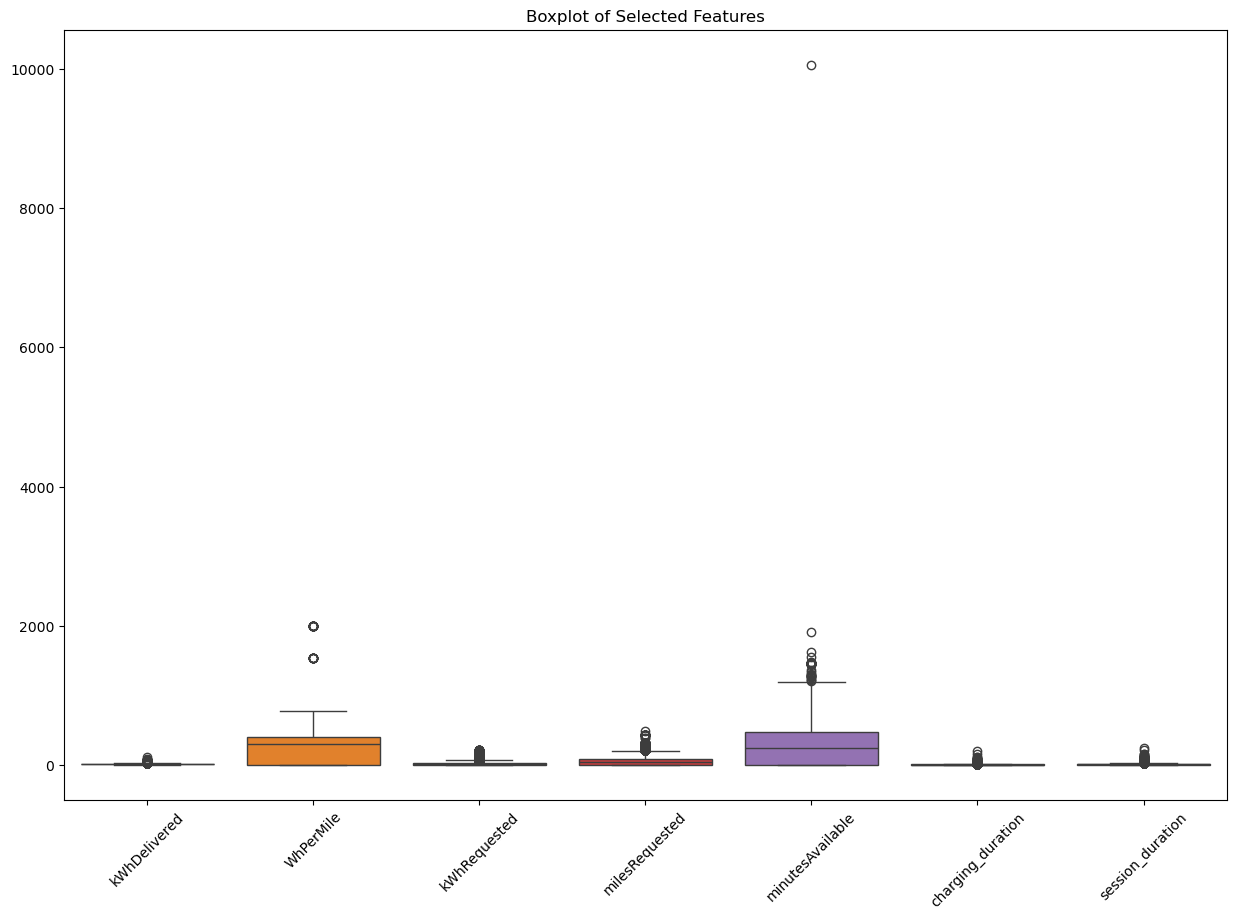

In [1519]:
# List of columns to check for outliers
columns_to_check = [
    'kWhDelivered', 'WhPerMile', 'kWhRequested', 
    'milesRequested', 'minutesAvailable', 'charging_duration', 'session_duration'
]

# Create a boxplot for the specified features
plt.figure(figsize=(15, 10))
sns.boxplot(data=df[columns_to_check])
plt.title('Boxplot of Selected Features')
plt.xticks(rotation=45)
plt.show()

with one exeption there are no strong outliers in the data as seen in the boxplot visualizations and the models can deal with some outlieres. Therefor we do not need more deletion of outliers

To uncover as many relationships in the dataset as possible and get awareness of outliers, we use a pairplot. We intentionally excluded time-based features, categorical data, and unique identifiers, as they are not continuous numerical variables and would not contribute meaningful patterns to the pair plot analysis.

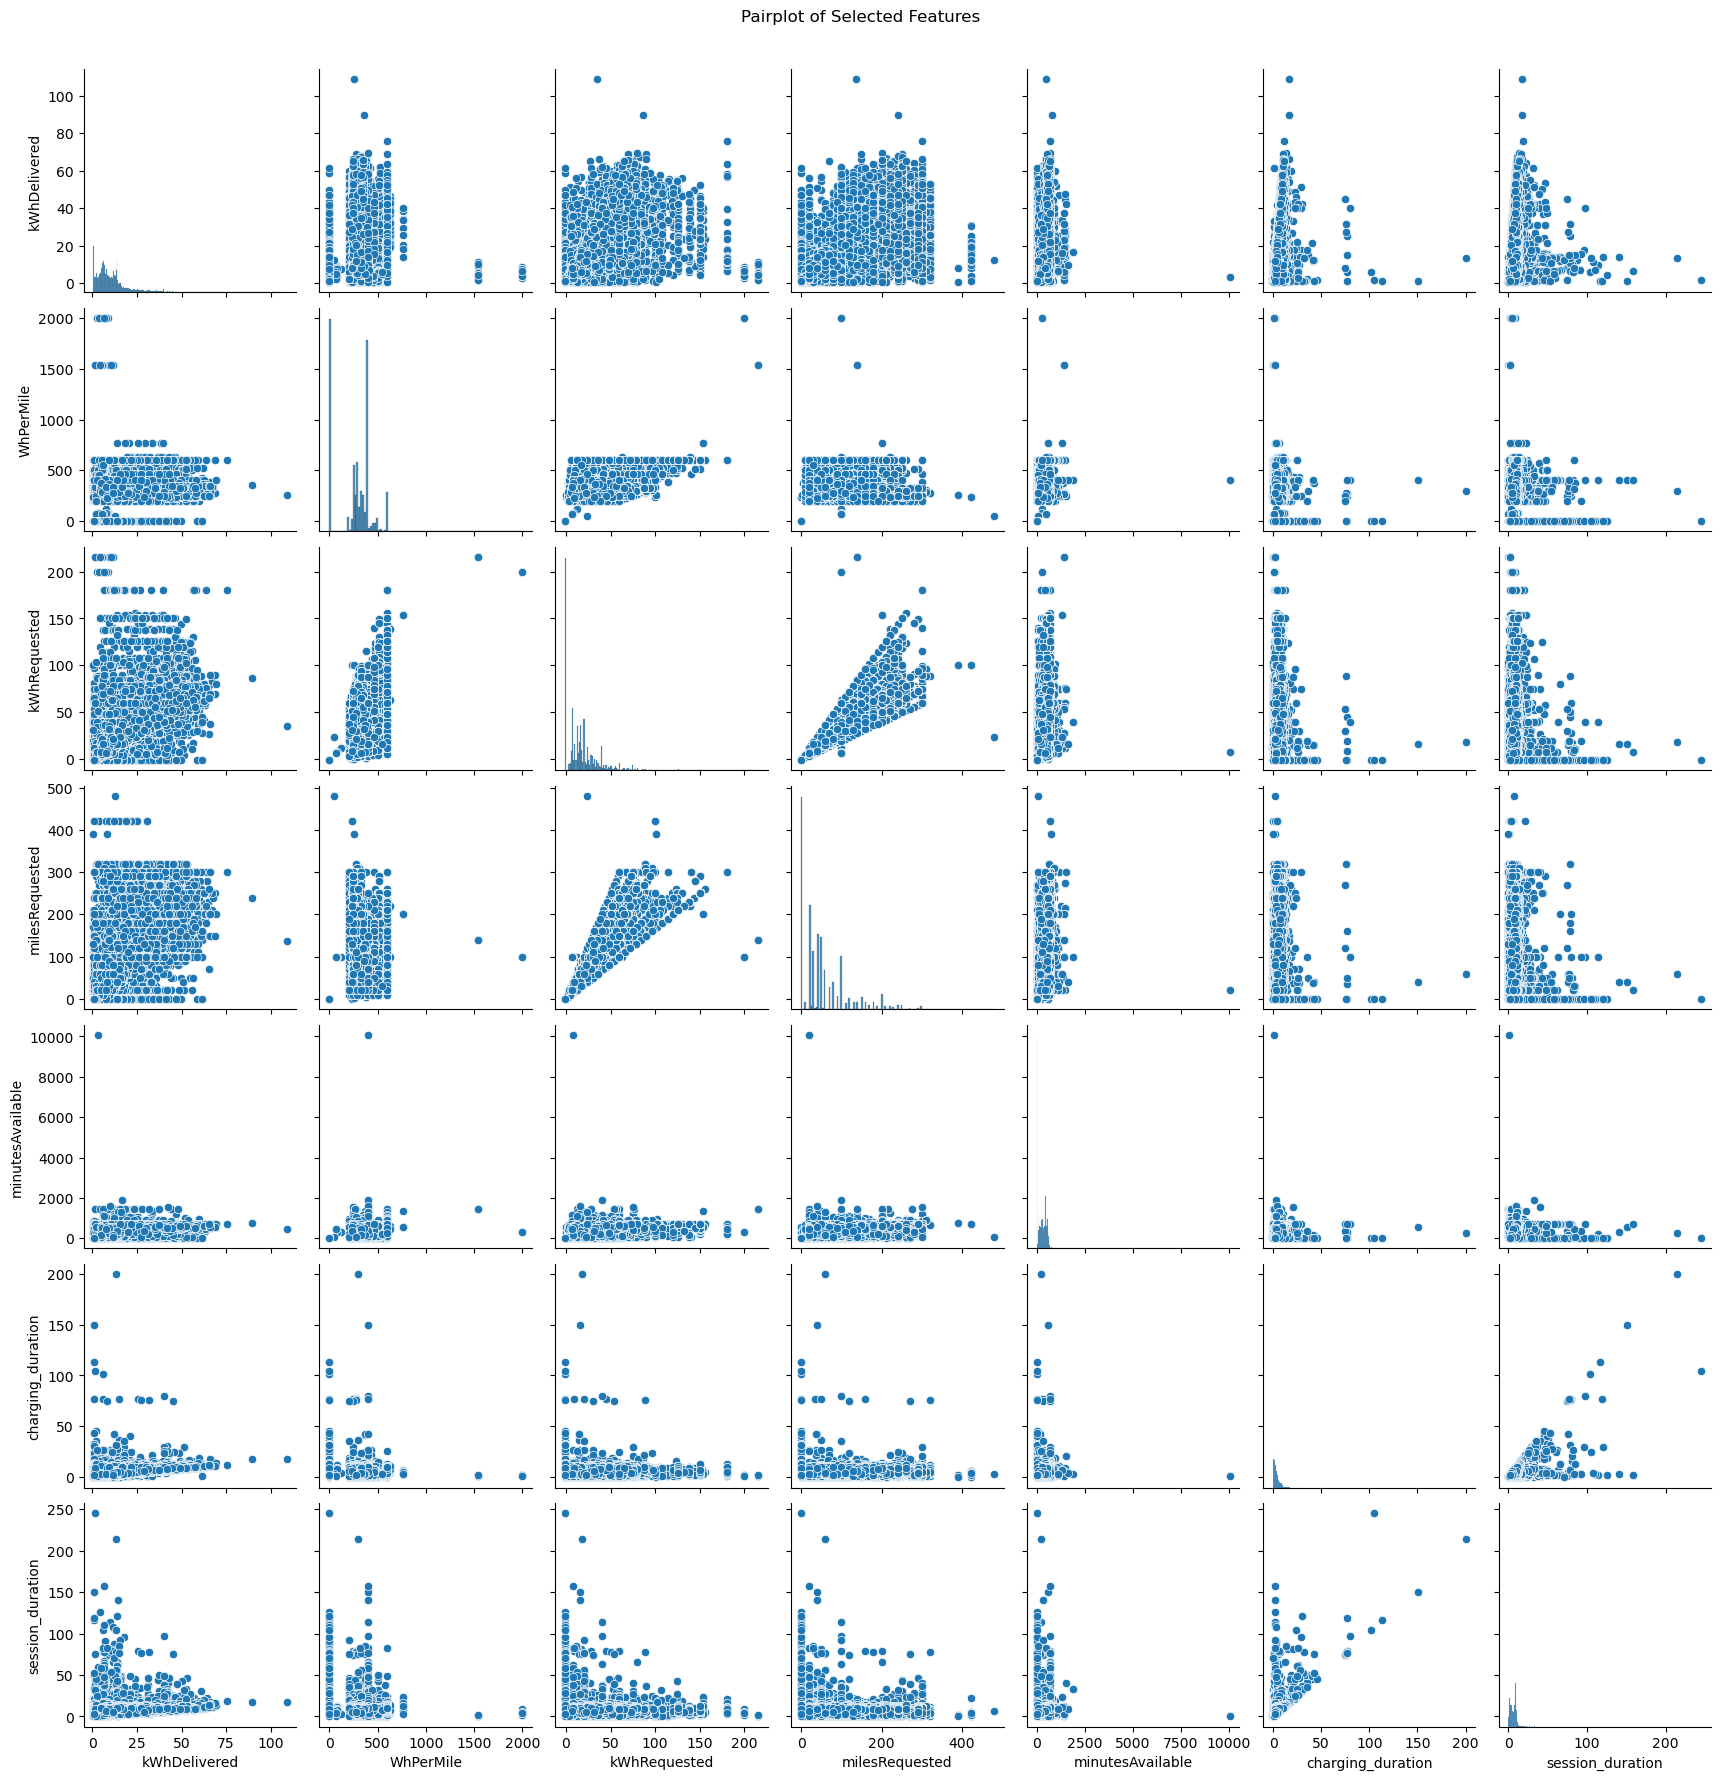

In [1520]:
columns_for_pairplot = [
    'kWhDelivered', 'WhPerMile', 'kWhRequested', 
    'milesRequested', 'minutesAvailable', 'charging_duration', 'session_duration'
]

sns.pairplot(df[columns_for_pairplot])
plt.suptitle('Pairplot of Selected Features', y=1.02)
plt.show()

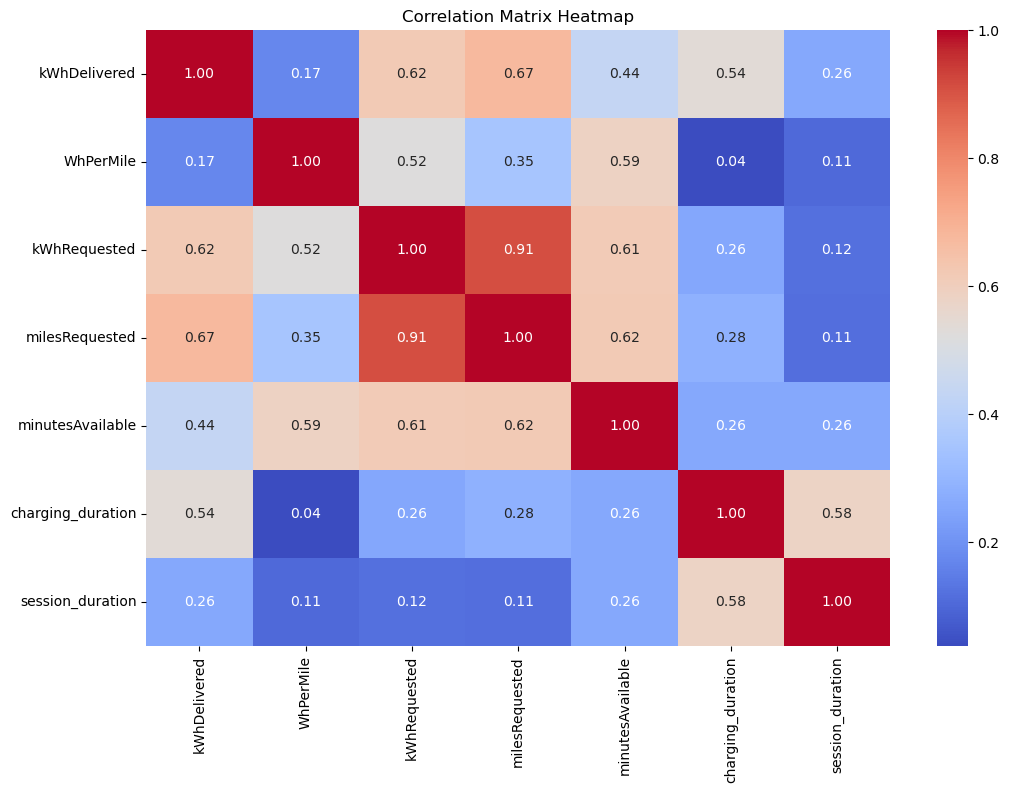

In [1521]:
# Corr. matrix
numeric_df = df[columns_for_pairplot].select_dtypes(include=['float64', 'int64'])

corr_matrix = numeric_df.corr()

plt.figure(figsize=(12, 8))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap="coolwarm", cbar=True)
plt.title("Correlation Matrix Heatmap")
plt.show()

The correlation matrix heatmap shows a strong positive correlation between kWhRequested and milesRequested (0.88), indicating that the amount of energy requested is closely related to the distance requested. Longer trips generally require more energy, and users who travel more kilometers tend to request more kWh.

Similarly, kWhDelivered and milesRequested (0.68) show that as distance increases, energy delivered also increases, showing the direct relationship between distance and energy demand. Users who want to cover a longer distance naturally require more energy for their journey, which leads to a higher delivered kWh.

The correlation between kWh delivered and kWh demanded (0.61) suggests that the energy delivered generally matches the energy demanded, although there may be some variation due to factors such as charging efficiency. In most cases, the amount of energy requested and the amount of energy supplied match accurately.

/var/folders/9g/v34g8lv55fl28x64t_hf8m000000gr/T/ipykernel_65105/3921507300.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='User Type', y='Number of Trips', data=user_trip_counts, palette='viridis')


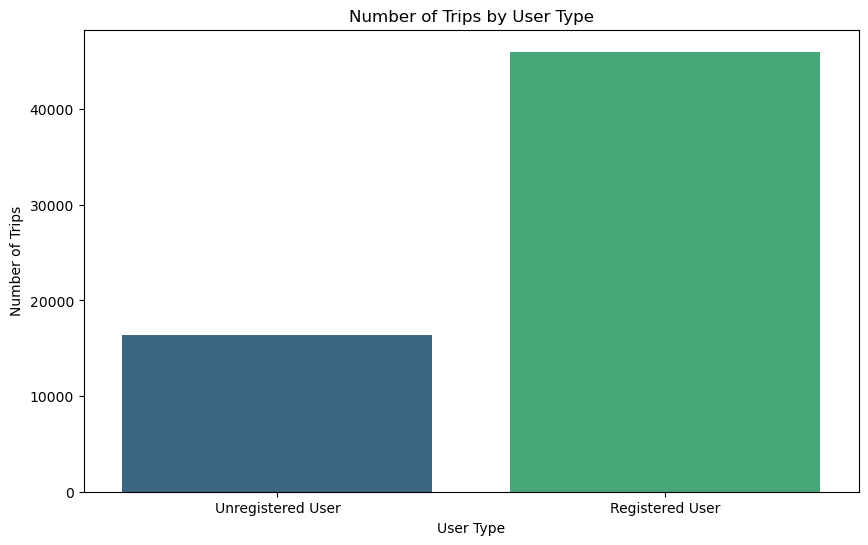

In [1522]:
# Group by isRegisteredUser and count the number of trips
user_trip_counts = df.groupby('isRegisteredUser').size().reset_index(name='Number of Trips')

# Map the isRegisteredUser values to more descriptive labels
user_trip_counts['User Type'] = user_trip_counts['isRegisteredUser'].map({0: 'Unregistered User', 1: 'Registered User'})

# Plot the number of trips for each user type
plt.figure(figsize=(10, 6))
sns.barplot(x='User Type', y='Number of Trips', data=user_trip_counts, palette='viridis')
plt.title('Number of Trips by User Type')
plt.xlabel('User Type')
plt.ylabel('Number of Trips')
plt.show()

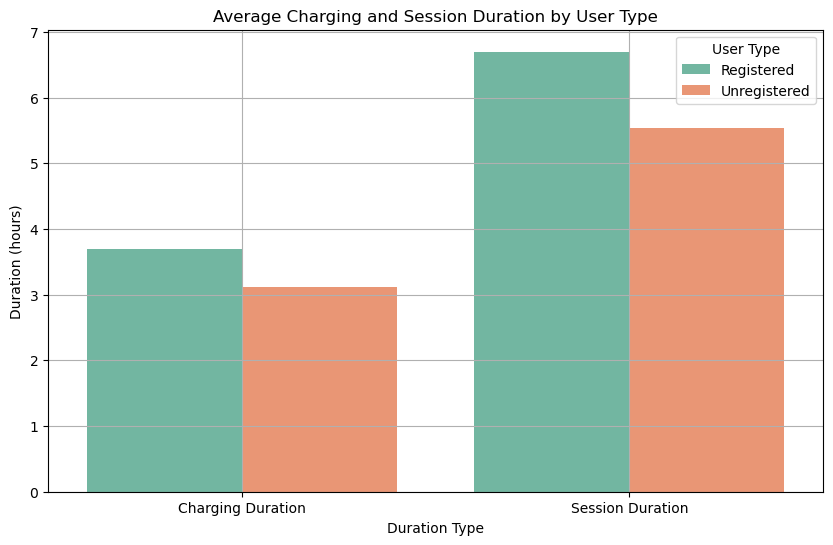

In [1523]:
df_registered = df[df['isRegisteredUser'] == 1]
df_unregistered = df[df['isRegisteredUser'] == 0]

mean_charging_duration_registered = df_registered['charging_duration'].mean()
mean_session_duration_registered = df_registered['session_duration'].mean()
mean_charging_duration_unregistered = df_unregistered['charging_duration'].mean()
mean_session_duration_unregistered = df_unregistered['session_duration'].mean()

# Create a DataFrame to hold the metrics
metrics_df = pd.DataFrame({
    'User Type': ['Registered', 'Registered', 'Unregistered', 'Unregistered'],
    'Duration Type': ['Charging Duration', 'Session Duration', 'Charging Duration', 'Session Duration'],
    'Duration (hours)': [
        mean_charging_duration_registered, 
        mean_session_duration_registered, 
        mean_charging_duration_unregistered, 
        mean_session_duration_unregistered
    ]
})

# Plot the metrics
plt.figure(figsize=(10, 6))
sns.barplot(data=metrics_df, x='Duration Type', y='Duration (hours)', hue='User Type', palette='Set2')
plt.title('Average Charging and Session Duration by User Type')
plt.xlabel('Duration Type')
plt.ylabel('Duration (hours)')
plt.legend(title='User Type')
plt.grid(True)
plt.show()

/var/folders/9g/v34g8lv55fl28x64t_hf8m000000gr/T/ipykernel_65105/2264202714.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=metrics_df, x='User Type', y='kWh Delivered', palette='Set2')


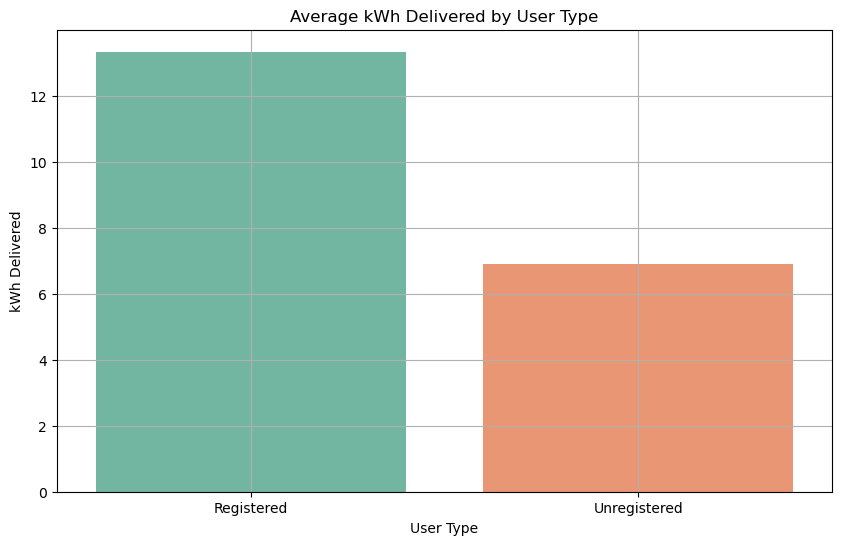

In [1524]:
mean_kWh_delivered_registered = df_registered['kWhDelivered'].mean()
mean_kWh_delivered_unregistered = df_unregistered['kWhDelivered'].mean()

# Create a DataFrame to hold the metrics
metrics_df = pd.DataFrame({
    'User Type': ['Registered', 'Unregistered'],
    'kWh Delivered': [mean_kWh_delivered_registered, mean_kWh_delivered_unregistered]
})

# Plot the metrics
plt.figure(figsize=(10, 6))
sns.barplot(data=metrics_df, x='User Type', y='kWh Delivered', palette='Set2')
plt.title('Average kWh Delivered by User Type')
plt.xlabel('User Type')
plt.ylabel('kWh Delivered')
plt.grid(True)

plt.show()

In [1525]:
# Filter for registered users who have to pay
payment = df_registered[df_registered['paymentRequired'] == True]["paymentRequired"].sum()
total = df_registered["paymentRequired"].sum()

# Calculate the ratio of payment required to total
ratio = payment / total

print(ratio)

1.0


All users that have an account are paying for the charging

# Task 2: Descriptive Analytics

## A)

/var/folders/9g/v34g8lv55fl28x64t_hf8m000000gr/T/ipykernel_65105/2789518033.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='hour', y='Charging Events', data=hourly_counts, palette='Spectral')


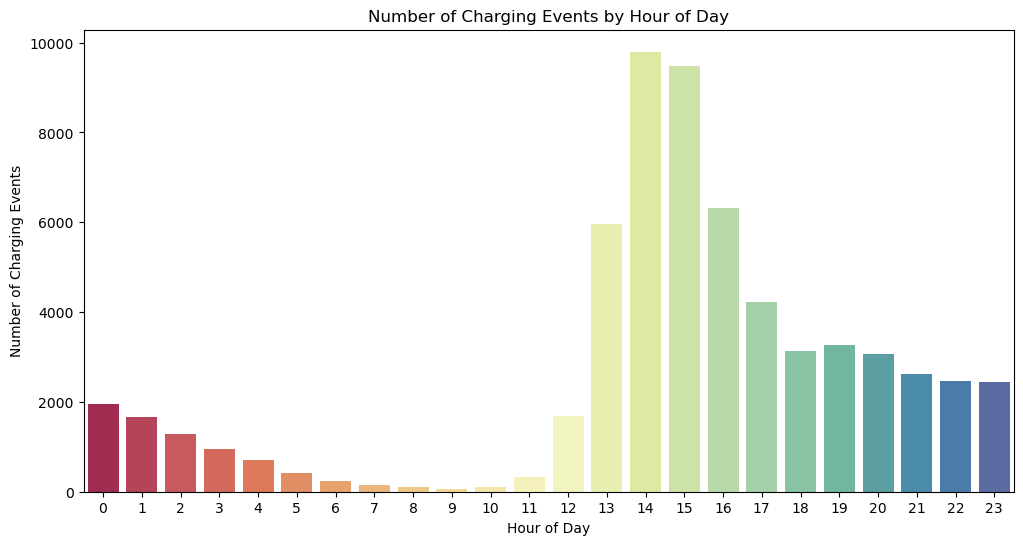

In [1526]:
hourly_counts = df.groupby('hour').size().reset_index(name='Charging Events')

plt.figure(figsize=(12, 6))
sns.barplot(x='hour', y='Charging Events', data=hourly_counts, palette='Spectral')
plt.title('Number of Charging Events by Hour of Day')
plt.xlabel('Hour of Day')
plt.ylabel('Number of Charging Events')
plt.xticks(range(0, 24))
plt.show()


During the early hours of the day (midnight to around 10:00) the charging activity is minimal. This could be due to users being still at home or not actively commuting. A noticebale increase in charging events starts at around 11:00 and reaches its highest point at 14:00. The high amount of users around midday could be due to people having a lunch break especially at public places using the time to charge their vehicles. After 14:00 the amount of charging is steadly sinking but staying relatively constant towards the evening hours. Some people may charge their vehicles over night or start a night shift at work.

/var/folders/9g/v34g8lv55fl28x64t_hf8m000000gr/T/ipykernel_65105/4277679158.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='hourDisconnected', y='Charging Events', data=hourly_counts_disconnect, palette='Spectral')


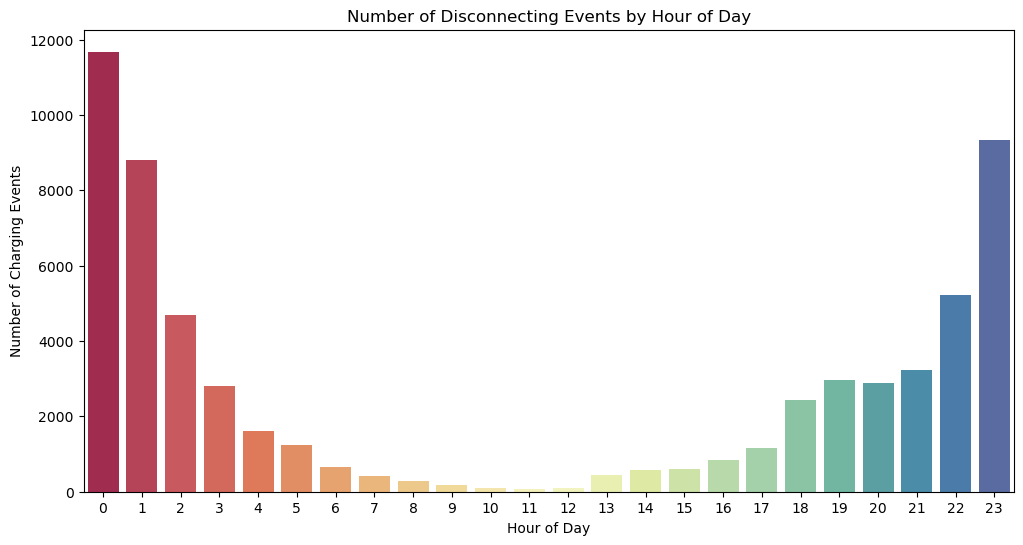

In [1527]:
hourly_counts_disconnect = df.groupby('hourDisconnected').size().reset_index(name='Charging Events')

plt.figure(figsize=(12, 6))
sns.barplot(x='hourDisconnected', y='Charging Events', data=hourly_counts_disconnect, palette='Spectral')
plt.title('Number of Disconnecting Events by Hour of Day')
plt.xlabel('Hour of Day')
plt.ylabel('Number of Charging Events')
plt.xticks(range(0, 24))
plt.show()

/var/folders/9g/v34g8lv55fl28x64t_hf8m000000gr/T/ipykernel_65105/3484256828.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='dayName', y='Loading OverNight Events', data=loading_overnight_counts, palette='Blues_d')


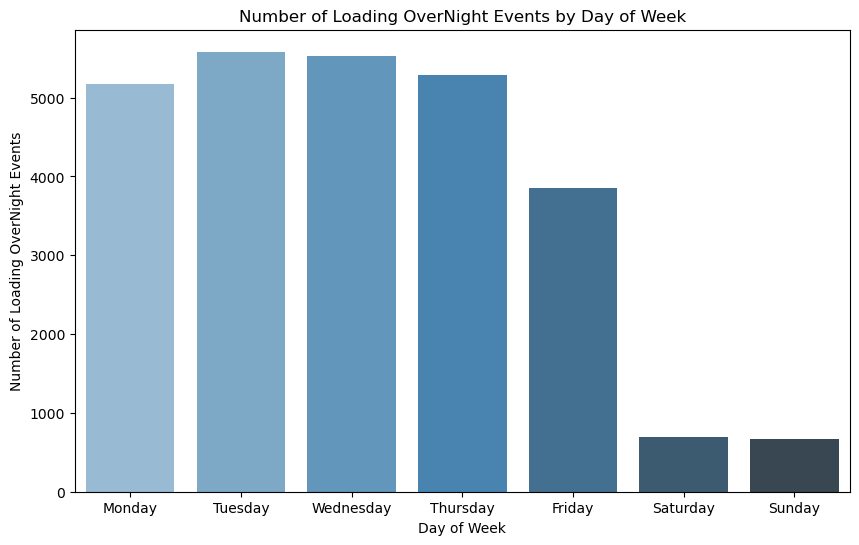

In [1528]:
# Group by day of the week and count the number of loadingOverNight events
loading_overnight_counts = df[df['loadingOverNight']].groupby('dayOfWeek').size().reset_index(name='Loading OverNight Events')
loading_overnight_counts['dayName'] = loading_overnight_counts['dayOfWeek'].map(day_names)
loading_overnight_counts['dayName'] = pd.Categorical(loading_overnight_counts['dayName'], categories=order, ordered=True)
loading_overnight_counts = loading_overnight_counts.sort_values('dayName')

# Plot the number of loadingOverNight events by day of the week
plt.figure(figsize=(10, 6))
sns.barplot(x='dayName', y='Loading OverNight Events', data=loading_overnight_counts, palette='Blues_d')
plt.title('Number of Loading OverNight Events by Day of Week')
plt.xlabel('Day of Week')
plt.ylabel('Number of Loading OverNight Events')
plt.show()

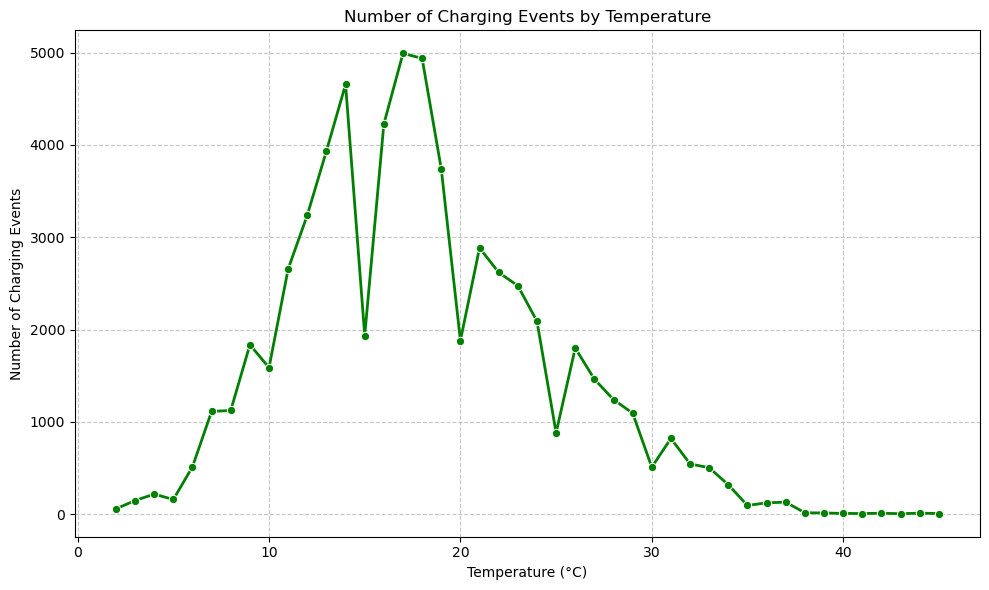

In [1529]:
#import weather data

df_weather = pd.read_csv("./Data/weather_burbank_airport.csv")
df_weather.drop(columns=['city', 'cloud_cover', 'cloud_cover_description', 'pressure', 'felt_temperature','windspeed'], inplace=True)
df_weather["date"] = pd.to_datetime(df_weather['timestamp']).dt.date
df_weather["hour"] = pd.to_datetime(df_weather['timestamp']).dt.hour
df_weather.drop(columns=['timestamp'], inplace=True)
df_weather['date'] = pd.to_datetime(df_weather['date'])  # Ensure datetime64[ns] in df_weather

# create df
df_counts_weather = df.copy()
df_counts_weather = df_counts_weather.rename(columns={'day': 'date'})
df_counts_weather['date'] = pd.to_datetime(df_counts_weather['date'])  # Ensure datetime64[ns] in df_weather
df_counts_weather = df_counts_weather.groupby(['date','hour']).size().reset_index(name='Charging Events')

# merge dataframes
df_merged_weather = pd.merge(df_counts_weather, df_weather, how='left', on=['date','hour'])

# drop missing values
df_merged_weather = df_merged_weather.dropna(subset=['temperature'])

# group by temperature
total_charging_events_temp = df_merged_weather.groupby("temperature")["Charging Events"].sum().reset_index()
total_charging_events_temp.columns = ["temperature", "total_charging_events"]

# Lineplot
plt.figure(figsize=(10, 6))
sns.lineplot(data=total_charging_events_temp, x="temperature", y="total_charging_events", marker="o", color="green", linewidth=2)
plt.title("Number of Charging Events by Temperature")
plt.xlabel("Temperature (°C)")
plt.ylabel("Number of Charging Events")
plt.grid(True, linestyle="--", alpha=0.7)
plt.tight_layout()
plt.show()


Charging events go up quickly from 0°C to around 15°C and are highest between 15°C and 20°C. After 20°C the amount of charging event decreases with very few events happening above 35°C. It suggests that people charge their vehicle more often when the temperature is moderate and less if it's very hot or very cold.

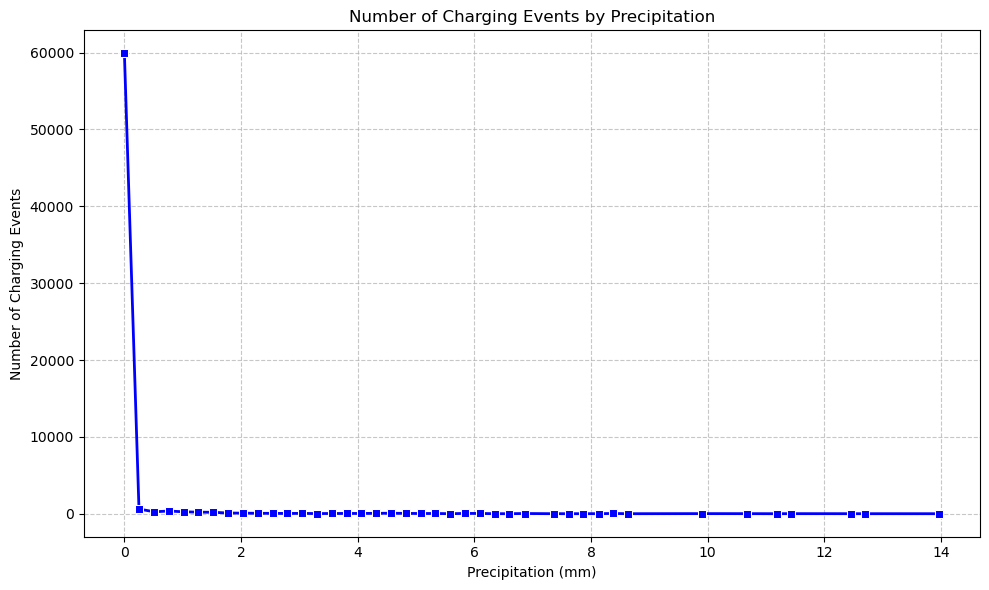

In [1530]:
#Number of charging events by precipitation

total_charging_events_prec = df_merged_weather.groupby("precipitation")["Charging Events"].sum().reset_index()
total_charging_events_prec.columns = ["precipitation", "total_charging_events"]
 
plt.figure(figsize=(10, 6))
sns.lineplot(data=total_charging_events_prec, x="precipitation", y="total_charging_events", marker="s", color="blue", linewidth=2)
plt.title("Number of Charging Events by Precipitation")
plt.xlabel("Precipitation (mm)")
plt.ylabel("Number of Charging Events")
plt.grid(True, linestyle="--", alpha=0.7)
plt.tight_layout()
plt.show()


The plot shows that at a precipitation of 0 the number of charging events is really high which makes interpreting the rest of the data harder. In the following plot the precipitation of 0 will be excluded to gain further insights.

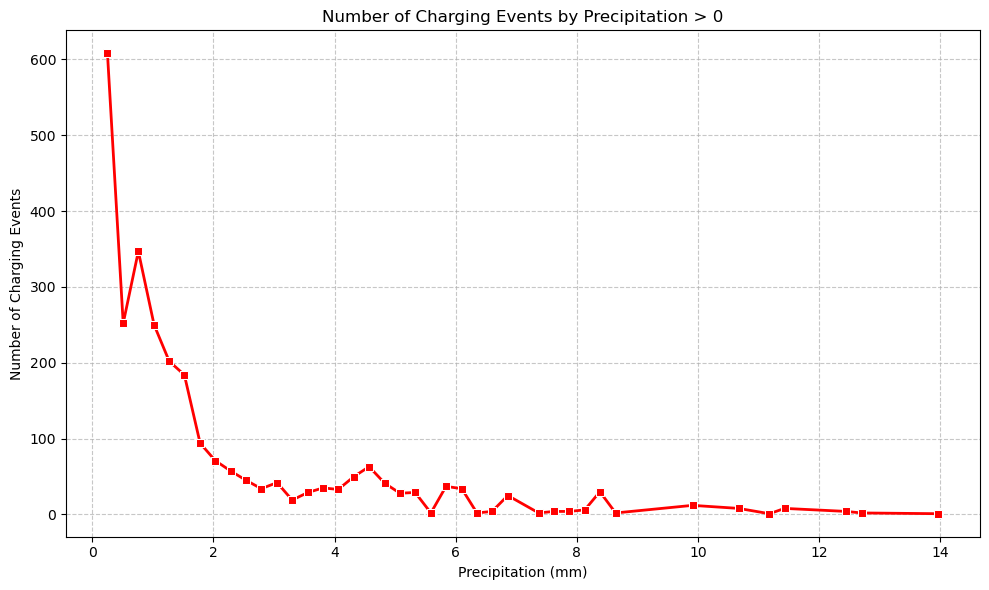

In [1531]:
# filter data for precipitation > 0
total_charging_events_prec_filtered = total_charging_events_prec[total_charging_events_prec["precipitation"] > 0]

plt.figure(figsize=(10, 6))
sns.lineplot(data=total_charging_events_prec_filtered, x="precipitation", y="total_charging_events", marker="s", color="red", linewidth=2)
plt.title("Number of Charging Events by Precipitation > 0")
plt.xlabel("Precipitation (mm)")
plt.ylabel("Number of Charging Events")
plt.grid(True, linestyle="--", alpha=0.7)
plt.tight_layout()
plt.show()


It can be observed that the number of charging events is sinking as precipitation increases. This suggests that rainy weather could have a negative impact on charging activity.

/var/folders/9g/v34g8lv55fl28x64t_hf8m000000gr/T/ipykernel_65105/1650979107.py:7: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.lineplot(x='dayName', y='Charging Events', data=weekly_counts, palette='Greens_d', marker='o')


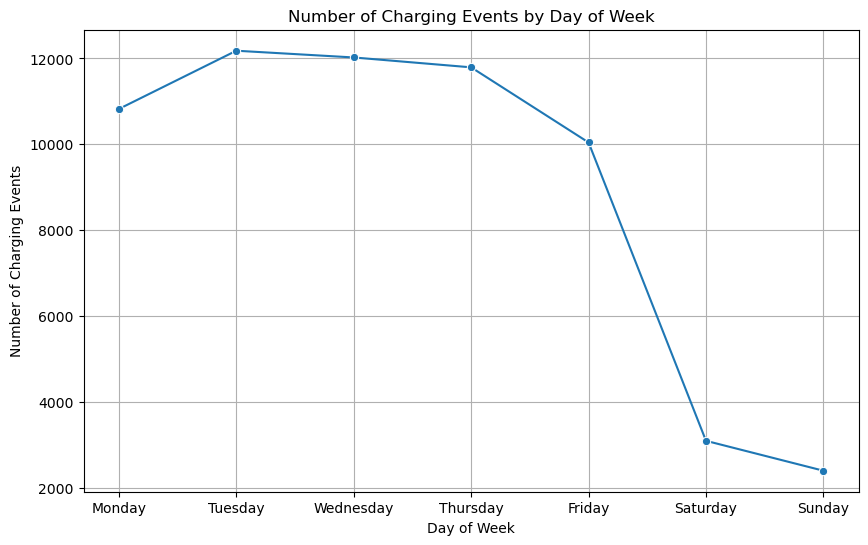

In [1532]:
weekly_counts = df.groupby('dayOfWeek').size().reset_index(name='Charging Events')
weekly_counts['dayName'] = weekly_counts['dayOfWeek'].map(day_names)
weekly_counts['dayName'] = pd.Categorical(weekly_counts['dayName'], categories=order, ordered=True)
weekly_counts = weekly_counts.sort_values('dayName')

plt.figure(figsize=(10, 6))
sns.lineplot(x='dayName', y='Charging Events', data=weekly_counts, palette='Greens_d', marker='o')
plt.title('Number of Charging Events by Day of Week')
plt.xlabel('Day of Week')
plt.ylabel('Number of Charging Events')
plt.grid(True)
plt.show()

The number of charging events by the day of the week shows a distinct pattern. Weekdays show a conistent high volume of events whereas the weekend experiences low numbers of charging events. This could align with people heading to work weekdays and some people charging their vehicle on the weekend on a public place.

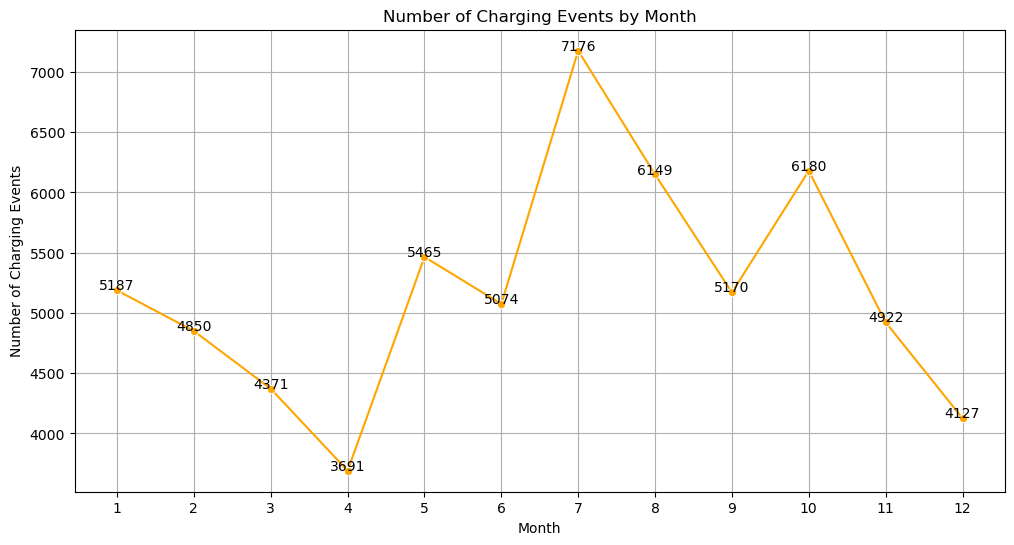

In [1533]:
import matplotlib.pyplot as plt
import seaborn as sns

monthly_counts = df.groupby('month').size().reset_index(name='Charging Events')

plt.figure(figsize=(12, 6))
sns.lineplot(x='month', y='Charging Events', data=monthly_counts, marker='o', color='orange')

for index, row in monthly_counts.iterrows():
    plt.text(
        row['month'], 
        row['Charging Events'] + 5,  
        f"{row['Charging Events']}", 
        horizontalalignment='center', 
        fontsize=10, 
        color='black'
    )

# Add titles and labels
plt.title('Number of Charging Events by Month')
plt.xlabel('Month')
plt.ylabel('Number of Charging Events')
plt.xticks(range(1, 13)) 
plt.grid(True)
plt.show()


A noticeable decline in charging events can be observed in April. After that numbers rise sharply and reach their peak in July. After July, a steady decline until September can be seen. In October, there the charging events increase again before droping towards the end of the year. The seasonal variations indicate that charging behaviors could be influenced by external factors such as weather conditions, holiday periods or commuting habits.

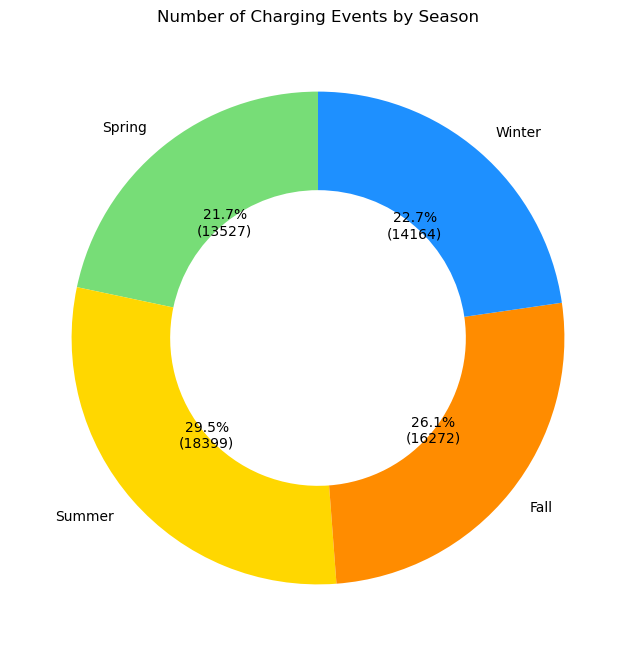

In [1534]:
df["season"] = df['month'].apply(get_season)
seasonly_counts = df.groupby('season').size().reset_index(name='Charging Events')
season_order = ['Spring', 'Summer', 'Fall', 'Winter']
seasonly_counts['season'] = pd.Categorical(seasonly_counts['season'], categories=season_order, ordered=True)
seasonly_counts = seasonly_counts.sort_values('season')
seasons = seasonly_counts['season']
charging_events = seasonly_counts['Charging Events']
custom_palette = {
    'Spring': '#77DD77',  
    'Summer': '#FFD700',  
    'Fall': '#FF8C00',   
    'Winter': '#1E90FF', 
}
colors = [custom_palette[season] for season in seasons]

def autopct_with_totals(pct, all_vals):
    total = sum(all_vals)
    absolute = int(round(pct / 100.0 * total))
    return f"{pct:.1f}%\n({absolute})"

plt.figure(figsize=(8, 8))
plt.pie(
    charging_events, 
    labels=seasons, 
    autopct=lambda pct: autopct_with_totals(pct, charging_events), 
    colors=colors, 
    startangle=90, 
    wedgeprops={'width': 0.4}, 
    textprops={'fontsize': 10}  
)

plt.title('Number of Charging Events by Season')
plt.show()

The data clearly shows that summer experiences the highest number of charging events. This is also aligning with the peak in July seen in the last graph. Following summer, there is a consistent reduction in charging activity until the end of the year. The graph makes clear that seasonal factors impact the charging events. These could be due to increased traveling and outdoor activities in summer and recuded mobility in colder months of the year.

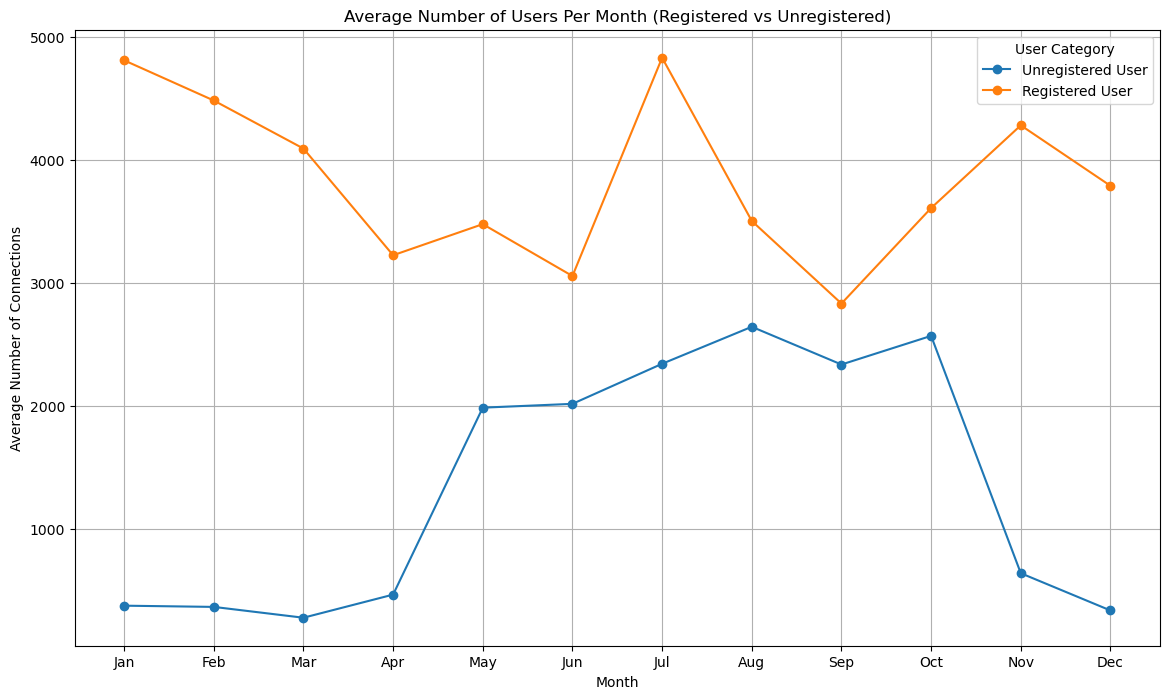

In [1535]:

df['Month'] = df['connectionTime'].dt.month
monthly_average_users = df.groupby(['Month', 'isRegisteredUser']).size().reset_index(name='Connections')
monthly_average_users_pivot = monthly_average_users.pivot(index='Month', columns='isRegisteredUser', values='Connections').fillna(0)
monthly_average_users_pivot.columns = ['Unregistered User', 'Registered User']
monthly_average_users_pivot.plot(kind='line', marker='o', figsize=(14, 8))
plt.title('Average Number of Users Per Month (Registered vs Unregistered)')
plt.xlabel('Month')
plt.ylabel('Average Number of Connections')
plt.xticks(ticks=range(1, 13), labels=['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])
plt.legend(title='User Category')
plt.grid(True)
plt.show()


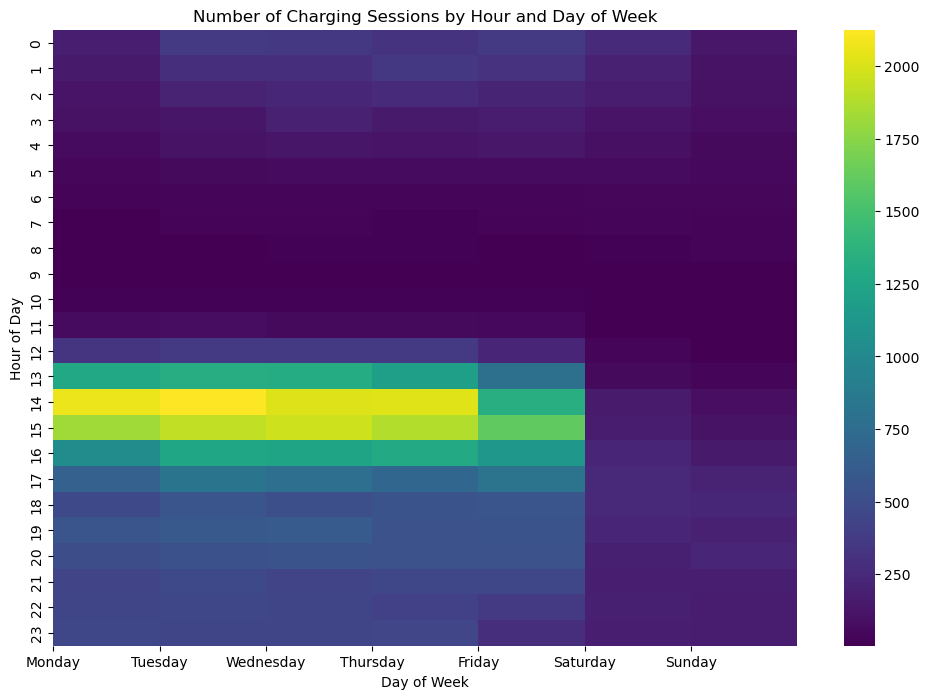

In [1536]:
## Heatmap of charging sessions
heatmap_data = df.groupby(['hour', 'dayOfWeek']).size().unstack()
plt.figure(figsize=(12, 8))
sns.heatmap(heatmap_data, cmap='viridis')
plt.title('Number of Charging Sessions by Hour and Day of Week')
plt.xlabel('Day of Week')
plt.ylabel('Hour of Day')
plt.xticks(range(0, 7), day_names.values())
plt.show()

The heatmap provides a visualization of the charging sessions distributed across the days of the week and the hours of the day. The color intensity indicates the number of charging sessions, with brighter colors reflecting higher activity and darker shades showing lower activity.

The data highlights distinct patterns. Weekdays experience a peak in charging activity between 12:00 and 16:00 shown by the yellow and green highlighted areas. Here again possibly due to lunchtime or charging at a public site while going for groceries. Weekends show a reduced activity across all hours. Friday serves as a transitional day, with high activity during the day but a slight dip compared to earlier weekdays. This could be due to people heading into the weekend.

To enable a more detailed analysis, Chapter 2c will examine the data by separating it based on individual sites (siteID 1 and siteID 2). This approach aims to identify site-specific patterns and highlight any differences in charging behavior between the two locations.

## B)

### KPI 1: Energy delivered per hour
This KPI is important because it provides a good overview of the hubs activity/how much energy is being utalized. 
It reflects the overall demand for charging services, which is directly tied to revenue (assuming a pricing model per kWh). Trends can be used for further forcasting the demand in the future. 

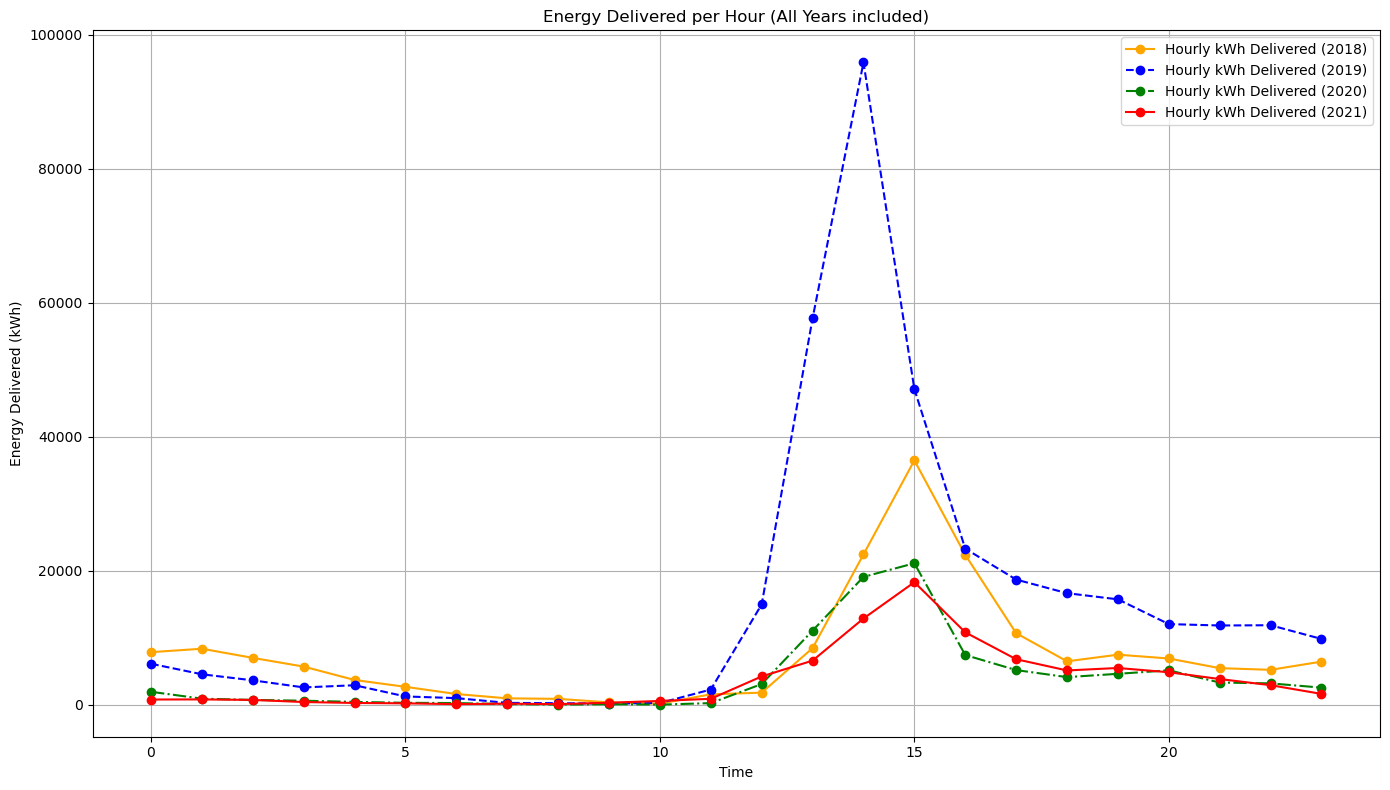

In [1537]:
# Group data by year & hour for the hourly energy delivered
yearly_data = df.groupby(['year', 'hour']).agg(
    energy_delivered=('kWhDelivered', 'sum')
).reset_index()

# Plot energy delivered per hour for all years in rthe df
fig, ax = plt.subplots(figsize=(14, 8))

# Set colors for each year in df to make it visually differentiable
colors = ['orange', 'blue', 'green', 'red']
line_styles = ['-', '--', '-.', '-']

# Loop through each year to plot
for idx, year in enumerate(sorted(yearly_data['year'].unique())):
    year_subset = yearly_data[yearly_data['year'] == year]
    
    # Plot hourly energy delivered
    ax.plot(
        year_subset['hour'], 
        year_subset['energy_delivered'], 
        marker='o', 
        linestyle=line_styles[idx % len(line_styles)], 
        color=colors[idx % len(colors)], 
        label=f'Hourly kWh Delivered ({year})'
    )

ax.set_title('Energy Delivered per Hour (All Years included)')
ax.set_xlabel('Time')
ax.set_ylabel('Energy Delivered (kWh)')
ax.legend()
ax.grid(True)

plt.tight_layout()
plt.show()


#### Since the chart has too many data points included, it is necessary to split the chart into multiple ones for better interpretability. For each year, one chart is included. Additionally to the kWhDelivered, mean value is included for each day.

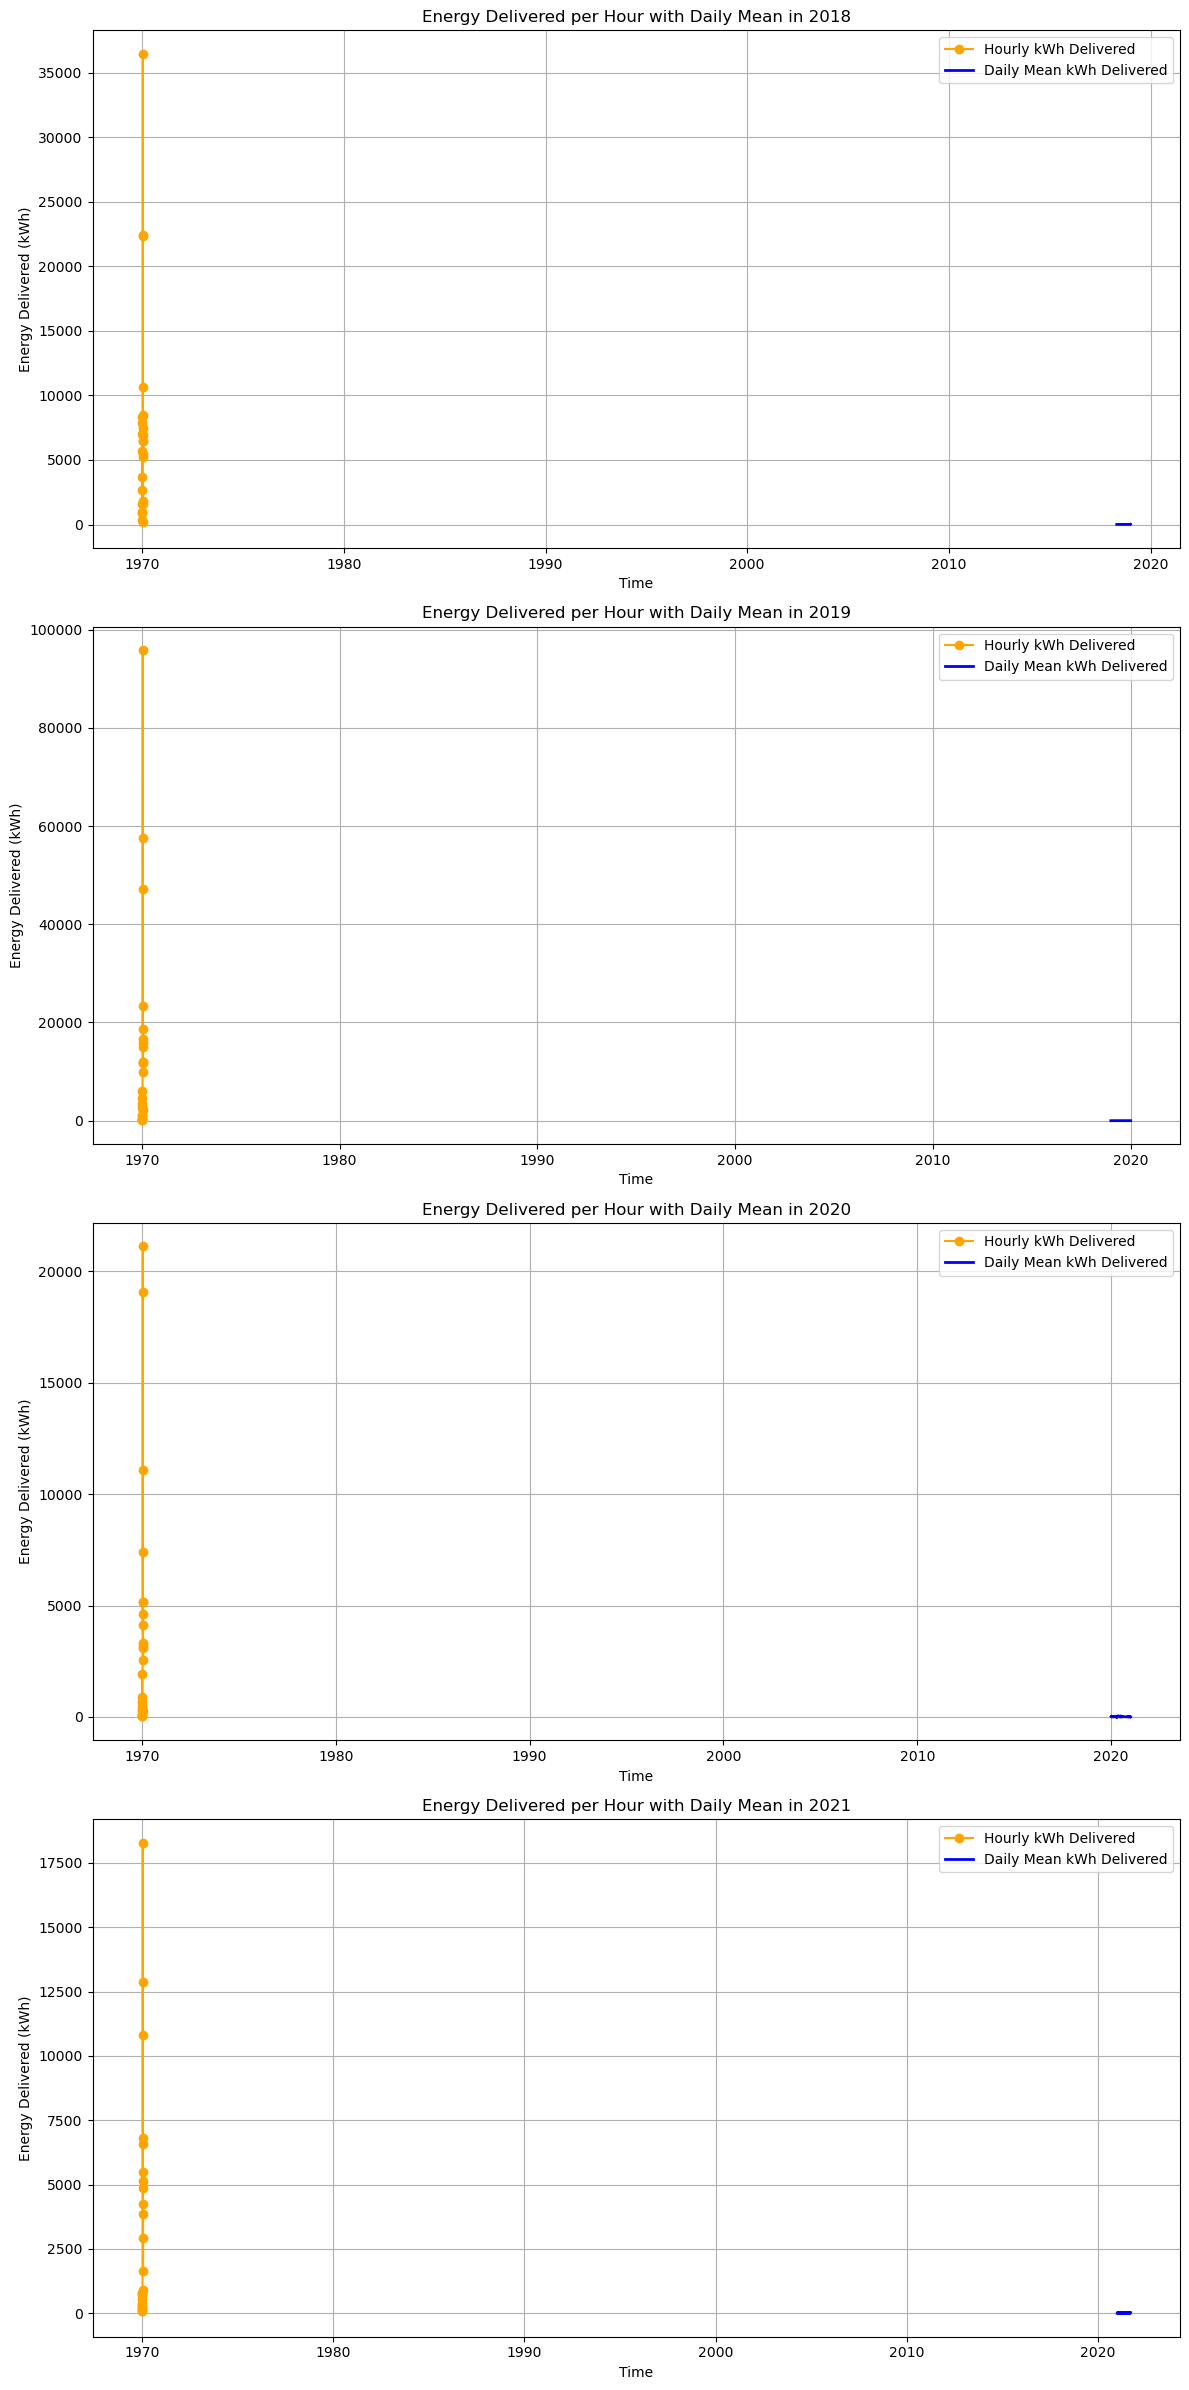

In [1538]:
# Group data by year and hour for the hourly energy delivered
yearly_data = df.groupby(['year', 'hour']).agg(
    energy_delivered=('kWhDelivered', 'sum')
).reset_index()

# Calculate the mean kWh delivered/day
daily_mean_data = df.groupby(['year', 'day']).agg(
    daily_mean_kwh=('kWhDelivered', 'mean')
).reset_index()
daily_mean_data['day'] = pd.to_datetime(daily_mean_data['day'])

# Plot energy delivered per hour with daily mean overlay for each year
unique_years = yearly_data['year'].unique()
fig, axes = plt.subplots(len(unique_years), 1, figsize=(12, 6 * len(unique_years)))

for i, year in enumerate(unique_years):
    # Data for current year
    year_subset = yearly_data[yearly_data['year'] == year]
    daily_mean_subset = daily_mean_data[daily_mean_data['year'] == year]
    # Plot  hourly kWhdelivered
    axes[i].plot(year_subset['hour'], year_subset['energy_delivered'], marker='o', color='orange', label='Hourly kWh Delivered')
    # Plot the daily mean of kWhdelivered
    axes[i].plot(daily_mean_subset['day'], daily_mean_subset['daily_mean_kwh'], color='blue', linewidth=2, label='Daily Mean kWh Delivered')
    
    axes[i].set_title(f'Energy Delivered per Hour with Daily Mean in {year}')
    axes[i].set_xlabel('Time')
    axes[i].set_ylabel('Energy Delivered (kWh)')
    axes[i].grid(True)
    axes[i].legend()

plt.tight_layout()
plt.show()


#### Since there is anomaly in the data between August and mid November, further investigation is necessary. 

/var/folders/9g/v34g8lv55fl28x64t_hf8m000000gr/T/ipykernel_65105/972599664.py:7: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  filtered_data['hour'] = filtered_data['connectionTime'].dt.floor('H')


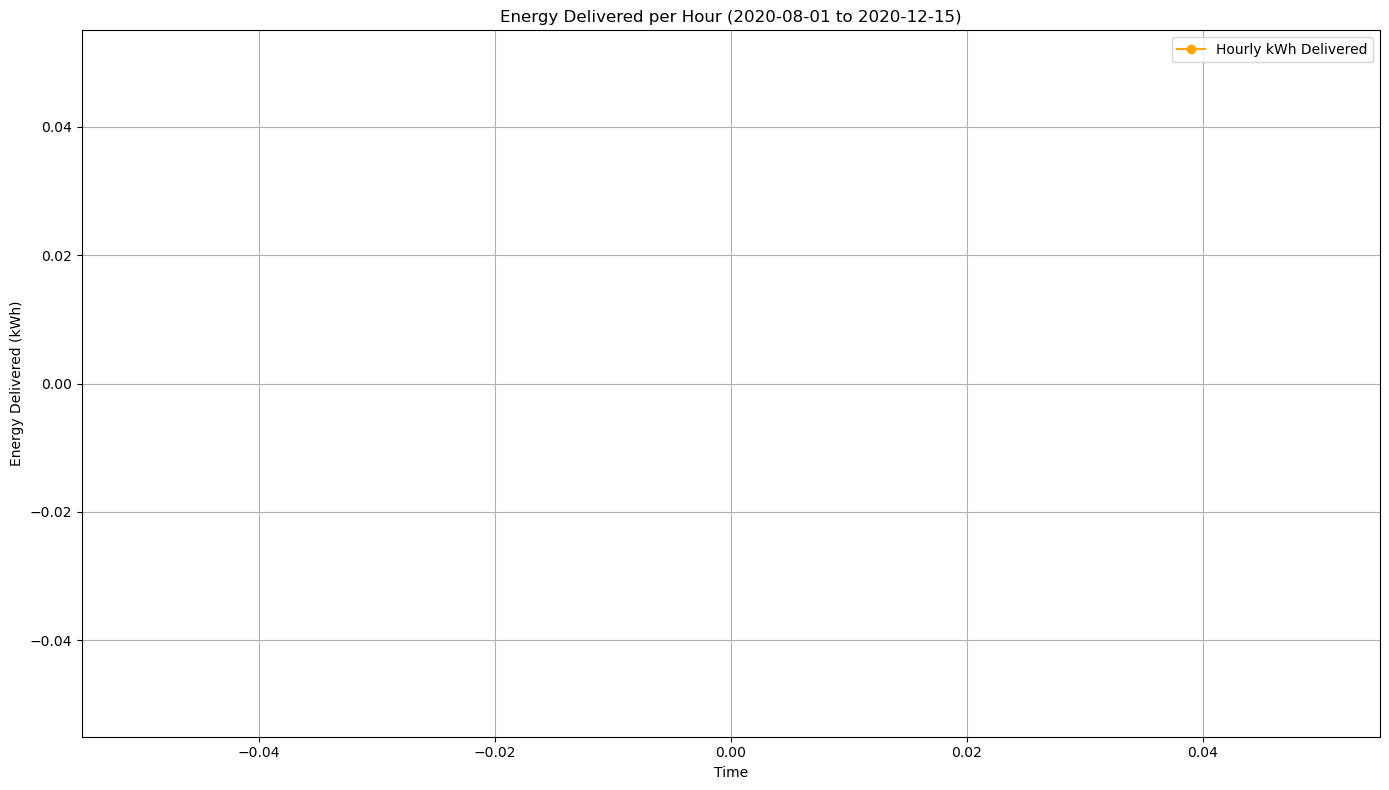

In [1539]:
# Filter data for the specified time range
filtered_data = df[
    (df['connectionTime'] >= '2020-08-04') & 
    (df['connectionTime'] <= '2020-11-17')
]

filtered_data['hour'] = filtered_data['connectionTime'].dt.floor('H')

# Group data by hour for the filtered range
filtered_hourly_data = filtered_data.groupby(['hour']).agg(
    energy_delivered=('kWhDelivered', 'sum')
).reset_index()

# Plot the filtered data
fig, ax = plt.subplots(figsize=(14, 8))

# Plot hourly energy delivered
ax.plot(
    filtered_hourly_data['hour'], 
    filtered_hourly_data['energy_delivered'], 
    marker='o', 
    color='orange', 
    label='Hourly kWh Delivered'
)
ax.set_title('Energy Delivered per Hour (2020-08-01 to 2020-12-15)')
ax.set_xlabel('Time')
ax.set_ylabel('Energy Delivered (kWh)')
ax.legend()
ax.grid(True)

plt.tight_layout()
plt.show()

In [1540]:
specific_range_data = filtered_data[
    (filtered_data['connectionTime'] >= '2020-08-04') & 
    (filtered_data['connectionTime'] <= '2020-11-17')
][['connectionTime', 'kWhDelivered']]
zero_values_count = specific_range_data['kWhDelivered'].eq(0).sum()
null_values_count = specific_range_data['kWhDelivered'].isnull().sum()



average_kwh = specific_range_data['kWhDelivered'].mean()
median_kwh = specific_range_data['kWhDelivered'].median()
# Display the filtered kWhDelivered values
average_kwh, median_kwh

excluded_data = df[
    (df['connectionTime'] < '2020-08-04') 
    | 
    (df['connectionTime'] > '2020-11-17')
]

# Calculate the average and median kWhDelivered for the excluded range
average_kwh_excluded = excluded_data['kWhDelivered'].mean()
median_kwh_excluded = excluded_data['kWhDelivered'].median()

# Display the results
average_kwh_excluded, median_kwh_excluded

print(zero_values_count,null_values_count,average_kwh_excluded, median_kwh_excluded, average_kwh, median_kwh)

0 0 11.643983837361155 9.029 nan nan


## KPI 2: Users with/without User-Account over time

This Metric helps to identify the change over time of Users that have an User Account. User with an account are more helpfull because with them, the manager can generate more data about typical user groups and how users charge their cars(When, How much, How often, Where,...) That creates user profiles that are very hepfull to improve the charging infractructure and improve the locations and measures of the charging stations, to improve the profitability and capacity utilization per station. With that the manager can decide if more efforts are important to higher the number of registrered users or if spefific happenings higher the proportion of registered users.

/var/folders/9g/v34g8lv55fl28x64t_hf8m000000gr/T/ipykernel_65105/2201908595.py:2: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  monthly_user_counts = df.groupby([df['connectionTime'].dt.to_period('M'), 'isRegisteredUser']).size().reset_index(name='Connections')


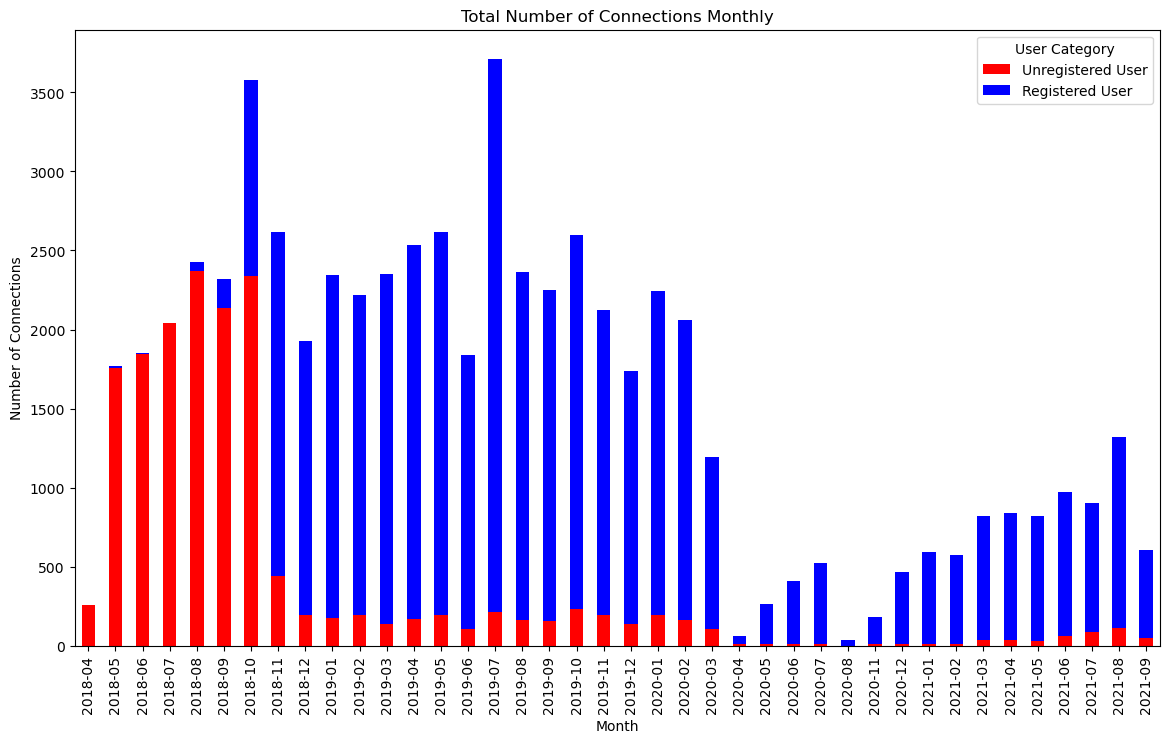

In [1541]:
# Group by month and user category to get the count of connections
monthly_user_counts = df.groupby([df['connectionTime'].dt.to_period('M'), 'isRegisteredUser']).size().reset_index(name='Connections')

# Pivot the data to have user categories as columns
monthly_user_counts_pivot = monthly_user_counts.pivot(index='connectionTime', columns='isRegisteredUser', values='Connections').fillna(0)

# Plot the data
monthly_user_counts_pivot.columns = ['Unregistered User', 'Registered User']
monthly_user_counts_pivot.plot(kind='bar', stacked=True, figsize=(14, 8), color=['red', 'blue'])
plt.title('Total Number of Connections Monthly')
plt.xlabel('Month')
plt.ylabel('Number of Connections')
plt.legend(title='User Category')
plt.show()

# Observation regarding missing kWhDelivered 
-The data between 04.08.2020 and 17.11.2020 has an average kWhDelivered of nan and mean of nan, while it is 11.643983837361155 and 9.029 on the whole dataset excluding this time range. Further investigation on why there are no values for kWhDelivered are available is necessary. 

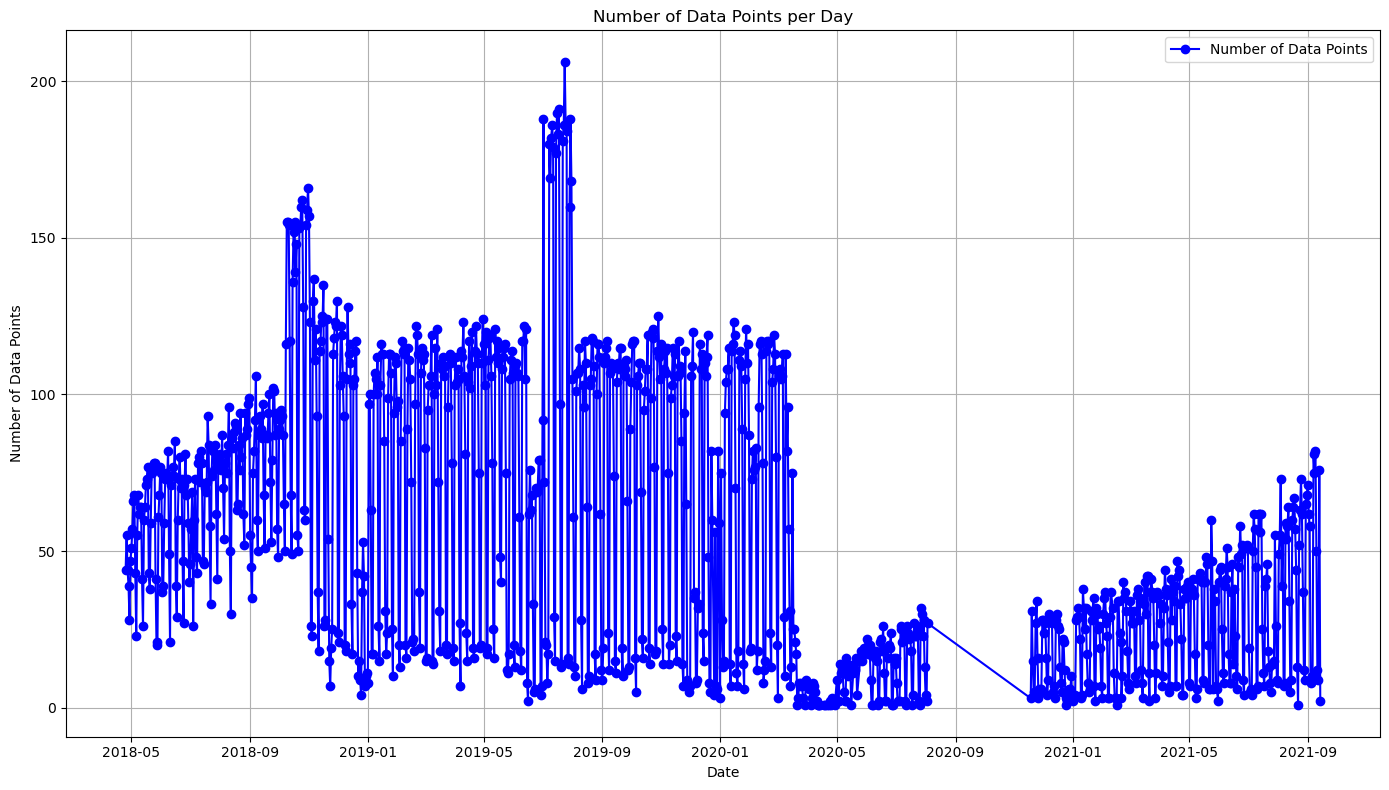

In [1542]:
# Group by date to count the number of data points per day
data_points_per_day = df.groupby(df['connectionTime'].dt.date).size().reset_index(name='data_points')

# Plot the number of data points over time
fig, ax = plt.subplots(figsize=(14, 8))

ax.plot(
    data_points_per_day['connectionTime'], 
    data_points_per_day['data_points'], 
    marker='o', 
    linestyle='-', 
    color='blue',
    label='Number of Data Points'
)

# Chart labels, legend, and grid
ax.set_title('Number of Data Points per Day')
ax.set_xlabel('Date')
ax.set_ylabel('Number of Data Points')
ax.legend()
ax.grid(True)

plt.tight_layout()
plt.show()

In [1543]:
# Verify if any data exists between 2020-08-04 and 2020-11-17
missing_period_data = df[
    (df['connectionTime'] >= '2020-08-04') & 
    (df['connectionTime'] <= '2020-11-17')
]

# Count the number of records in this range
missing_period_count = missing_period_data.shape[0]

# Display the result
print(missing_period_count)

0


### Observation regarding missing data: 
There are no data points between the 04.08.2020 and 17.11.2020. There could be a major reason: 
COVID-19 came with travel restrictions, lockdown and layoffs led to a radical decrease in mobility. 
This could have led to the closure of multiple stations
### Observations regarding the kWh Delivered over the whole timespan of the dataset
#### 2018
The energy delivered starts relativly low. The gradual increase over time can have these reasons: 
1. Increased demand because of more users having an EV 
2. Increased awareness of available charging stations 
#### 2019
There is a significant growth in delivered energy compared to 2018. A noticable peak is in the July and August, which aligns with the increased number of charging events detected in task 2a). 
#### 2020 
A hard decline is noticable in this year, noticably strong after the early year. The reason for that could be COVID-19.
#### 2021
Energy delivered begins to rebound, showing growth over time. Although delivery levels remain lower than in 2019, there is a upward trend, indicating:
1. Recovery of demand post-pandemic
2. Gradual return of regular charging behavior
3. Increasing adoption of electric vehicles

## KPI 3: Utilization Rate

The utilization rate measures how often the charging station is in use versus idle. This KPI is crucial for assessing the demand for charging services and ensuring operational efficiency. A high utilization rate indicates that the charging station is in high demand, suggesting the need to maintain or potentially expand charging capacity in the area. Conversely, a persistently low utilization rate might highlight inefficiencies or suboptimal placement of the charging station. By tracking the utilization rate, the operator can monitor demand patterns, infrastructure limitations, and user behavior.

$$
\text{Utilization Rate} = \frac{\text{time charging stations were in use}}{\text{total time available for use}}
$$

In [1544]:
# Calculates the utilization rate of charging stations for a given date
def calculate_utilization_rate(df, date):
    ef = df[df['connectionTime'].dt.date == pd.to_datetime(date).date()]
    total_stations = df['stationID'].nunique()
    time_stations_open_a_day = 24
    total_available_time = total_stations * time_stations_open_a_day
    total_occupied_time_per_station = ef.groupby('stationID')['session_duration'].sum()
    total_occupied_time_per_station = total_occupied_time_per_station.apply(lambda x: min(x, 24))
    total_occupied_time = total_occupied_time_per_station.sum()
    utilization_rate = (total_occupied_time / total_available_time) * 100
    return utilization_rate

# Calculate utilization rate for each day
def calculate_daily_utilization_rate(df):
    daily_utilization = []
    unique_dates = df['connectionTime'].dt.date.unique()
    
    for date in unique_dates:
        utilization_rate = calculate_utilization_rate(df, date)
        daily_utilization.append({'date': date, 'utilization_rate': utilization_rate})
    
    return pd.DataFrame(daily_utilization)

print(calculate_daily_utilization_rate(df))

            date  utilization_rate
0     2020-01-02         18.345169
1     2020-01-03          5.437293
2     2020-01-04          2.533761
3     2020-01-05          1.152527
4     2020-01-06         27.488775
...          ...               ...
1110  2019-06-25         21.190262
1111  2019-06-26         21.155584
1112  2019-06-27         22.539985
1113  2019-06-28         20.952448
1114  2019-06-29          0.637906

[1115 rows x 2 columns]


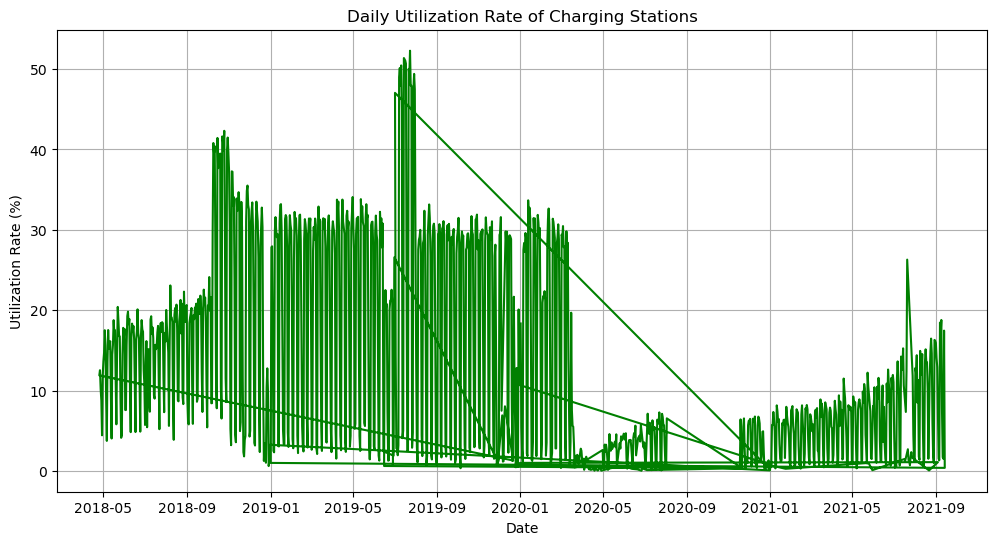

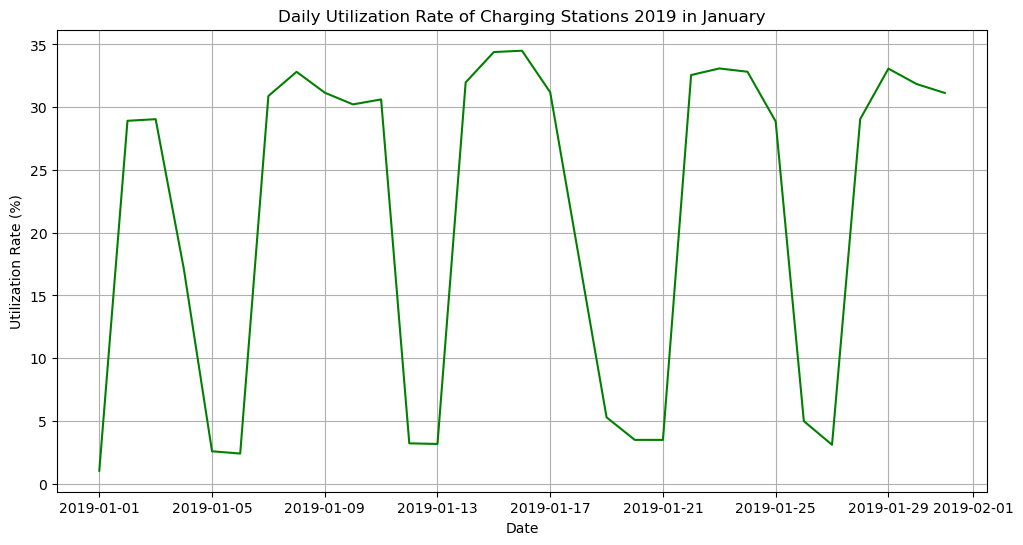

In [1545]:
daily_utilization_df = calculate_daily_utilization_rate(df)
daily_utilization_df.set_index('date', inplace=True)

plt.figure(figsize=(12, 6))
daily_utilization_df['utilization_rate'].plot(kind='line', color='green')
plt.title("Daily Utilization Rate of Charging Stations")
plt.xlabel("Date")
plt.ylabel("Utilization Rate (%)")
plt.grid(True)
plt.show()

daily_utilization_2019 = calculate_daily_utilization_rate(df[(df['connectionTime'].dt.year == 2019) & (df['connectionTime'].dt.month == 1)])
daily_utilization_2019.set_index('date', inplace=True)

plt.figure(figsize=(12, 6))
daily_utilization_2019['utilization_rate'].plot(kind='line', color='green')
plt.title("Daily Utilization Rate of Charging Stations 2019 in January")
plt.xlabel("Date")
plt.ylabel("Utilization Rate (%)")
plt.grid(True)
plt.show()

The daily utilization of the charging station shows a cyclical pattern that can be seen very clearly if you zoom in on a month (e.g. January 2019). The utilization rate often peaks and then drops to zero. This behavior corresponds to the typical usage on weekdays and the lower activity on weekends.

### Utilization Rate per hours a day

The hourly utilization rate provides a detailed view of when the charging station is at capacity and when not. With this metric the operator can identify peak usage times which could help to manage capacity during these hours. High hourly utilization can create spikes in energy demand. Therefore this information could help grid operators to prepare for load fluctuations.

In [1546]:
# Calculates the utilization rate of charging stations for a given date per hour
def calculate_utilization_rate_hourly(data, date):
    daily_data = data[data['connectionTime'].dt.date == pd.to_datetime(date).date()]
    total_stations = data['stationID'].nunique()

    hourly_usage_count = [0] * 24

    # iterate over daily_data
    for _, row in daily_data.iterrows():
        start_hour = row['connectionTime'].hour
        end_hour = row['disconnectTime'].hour
        for i in range(start_hour, end_hour):
            hourly_usage_count[i] += 1

    # calculate utilization rate
    hourly_utilization_rate = [min((count / total_stations), 1) * 100 for count in hourly_usage_count]

    return hourly_utilization_rate

# calculate the average utilization rate per hour
def calculate_avg_hourly_utilization_rate(data):
    hourly_utilization = []
    unique_dates = data['connectionTime'].dt.date.unique()
    
    for date in unique_dates:
        utilization_rate = calculate_utilization_rate_hourly(data, date)
        hourly_utilization.append(utilization_rate)
    
    hourly_utilization_df = pd.DataFrame(hourly_utilization, columns=range(24))
    avg_hourly_utilization = hourly_utilization_df.mean()
    
    return avg_hourly_utilization



/var/folders/9g/v34g8lv55fl28x64t_hf8m000000gr/T/ipykernel_65105/2607144060.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=range(24), y=hourly_utilization_rate, palette='summer')


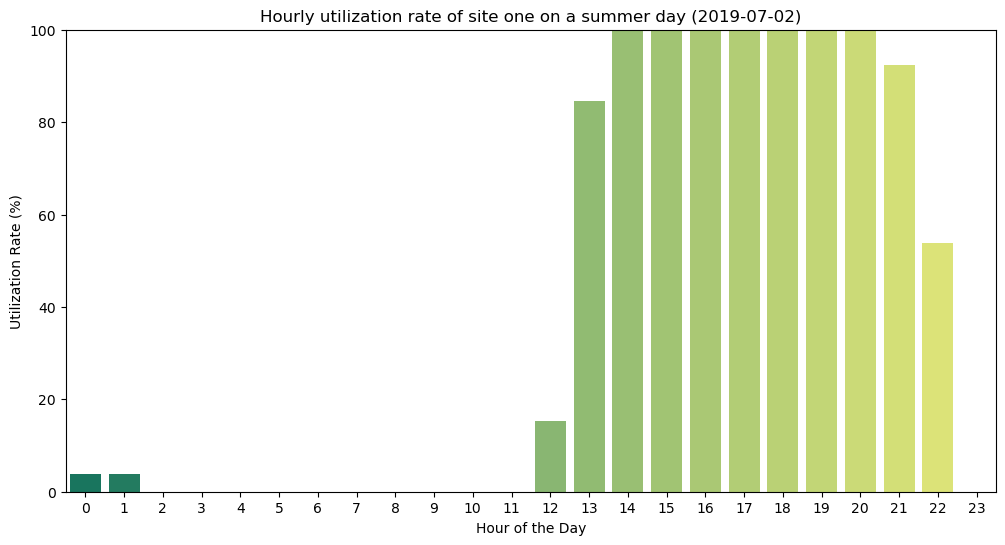

/var/folders/9g/v34g8lv55fl28x64t_hf8m000000gr/T/ipykernel_65105/2607144060.py:21: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=range(24), y=hourly_utilization_rate_avg_year, palette='summer')


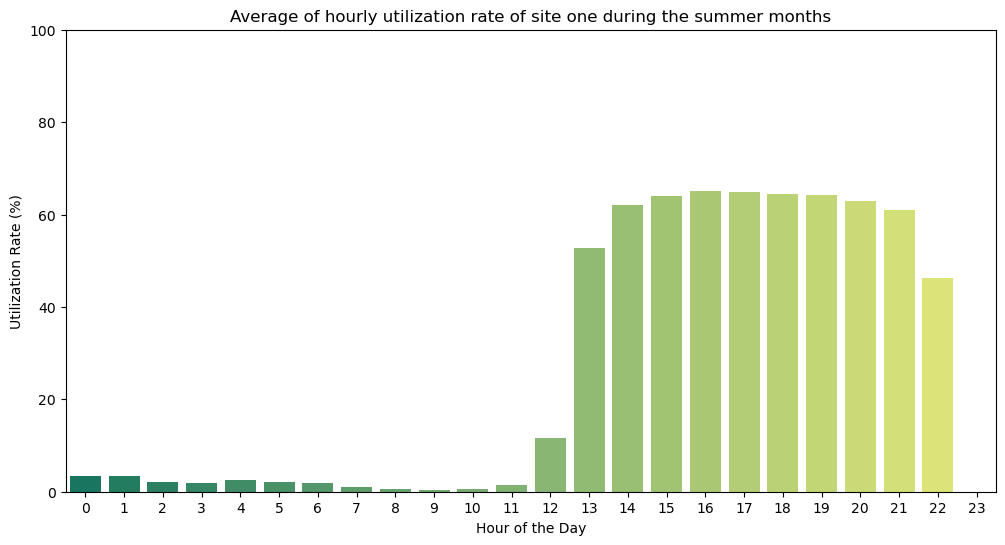

In [1547]:
# Calculate hourly utilization rate for a specific date
date = '2019-07-02' 
hourly_utilization_rate = calculate_utilization_rate_hourly(df_site_1, date)

plt.figure(figsize=(12, 6))
sns.barplot(x=range(24), y=hourly_utilization_rate, palette='summer')
plt.title(f'Hourly utilization rate of site one on a summer day ({date})')
plt.xlabel('Hour of the Day')
plt.ylabel('Utilization Rate (%)')
plt.xticks(range(0, 24))
plt.grid(False)
plt.ylim(0, 100)
plt.show()

df_2019_summer_station_1 = df_site_1[(df_site_1['year'] == 2019) & (df_site_1['month'] == 7)]

hourly_utilization_rate_avg_year = calculate_avg_hourly_utilization_rate(df_2019_summer_station_1)


plt.figure(figsize=(12, 6))
sns.barplot(x=range(24), y=hourly_utilization_rate_avg_year, palette='summer')
plt.title(f'Average of hourly utilization rate of site one during the summer months')
plt.xlabel('Hour of the Day')
plt.ylabel('Utilization Rate (%)')
plt.xticks(range(0, 24))
plt.grid(False)
plt.ylim(0, 100)
plt.show()

As we saw before, in the summer months of 2019 the utilization rate is quite high. When observing this KPI only for site one, we can see that this site is at full capacity for some hours during a summer day. Generally, we can observe a peak in usage in the afternoon for the average utilization. The specific day's data shows a peak between 14:00 and 18:00, while the average data shows a more consistent pattern with a similar peak time but less extreme variance. this suggests that while there are consistent peak times, individual days may vary. The consistently low usage during off-peak hours in both charts indicates an opportunity to optimize the charging infrastructure.

## C)

### Comparison charging events from the two sites

##### Number of Charging events by year and site

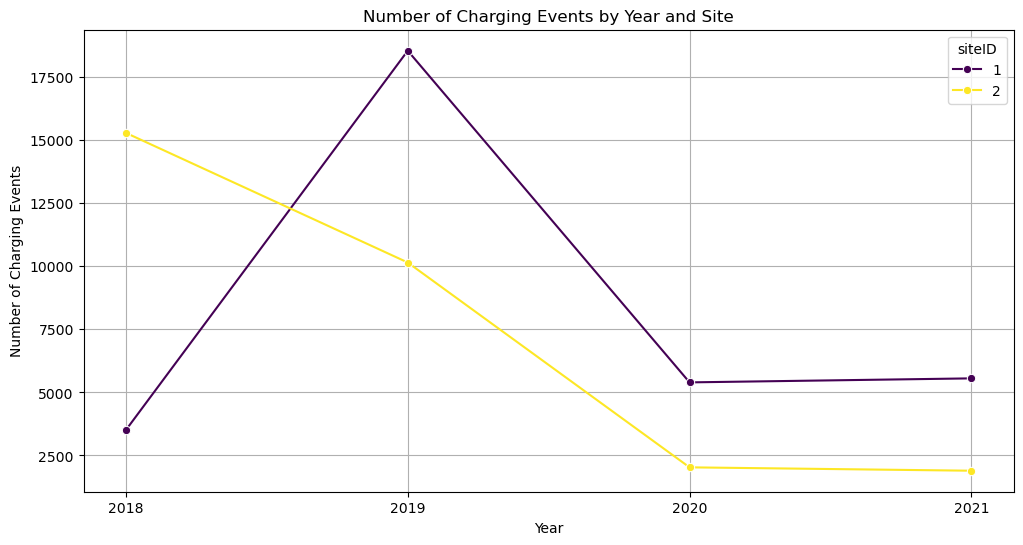

In [1548]:
# Group by site and year
site_yearly_counts = df.groupby(['siteID', 'year']).size().reset_index(name='Charging Events')

# Plot the charging events by year and site

plt.figure(figsize=(12, 6))
sns.lineplot(x='year', y='Charging Events', hue='siteID', data=site_yearly_counts, palette='viridis', marker='o')
plt.title('Number of Charging Events by Year and Site')
plt.xlabel('Year')
plt.xticks(ticks=site_yearly_counts['year'].unique(), labels=site_yearly_counts['year'].unique())
plt.ylabel('Number of Charging Events')
plt.grid(True)
plt.show()


The graph shows the number of EV charging events per year at the two different sites from 2018 to 2021. In 2018, Site 2 recorded more charging events than Site 1, but in 2019, Site 1 increased and site 2 decreased. However, from 2019 to 2020, both sites experienced a dramatic drop in charging activity. After 2020, the number of charging events remained relatively low. A possible explanation for this sharp decline after 2019 is the start of the COVID-19 pandemic in early 2020. Lockdowns, remote work, and reduced commuting likely contributed to the fewer charging events at both sites. A distinction between the two sites only based on the yearly charging events is insufficient to determine which site is public and which is private.

##### Number of charging events by month and site

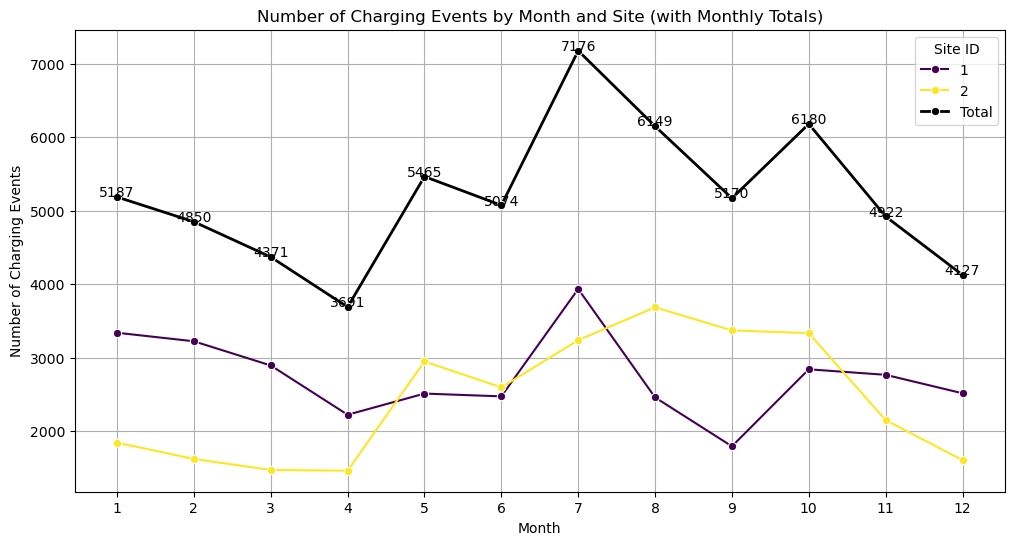

In [1549]:
# # Group by site and month
# site_monthly_counts = df.groupby(['siteID', 'month']).size().reset_index(name='Charging Events')

# # Plot the charging events by month
# plt.figure(figsize=(12, 6))
# sns.lineplot(x='month', y='Charging Events', hue='siteID', data=site_monthly_counts, palette='viridis', marker='o')
# plt.title('Number of Charging Events by Month and Site')
# plt.xlabel('Month')
# plt.xticks(range(1, 13))
# plt.ylabel('Number of Charging Events')
# plt.grid(True)
# plt.show()
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Group by site and month
site_monthly_counts = df.groupby(['siteID', 'month']).size().reset_index(name='Charging Events')

monthly_totals = site_monthly_counts.groupby('month')['Charging Events'].sum().reset_index()

# Plot the charging events by site and month
plt.figure(figsize=(12, 6))
sns.lineplot(x='month', y='Charging Events', hue='siteID', data=site_monthly_counts, palette='viridis', marker='o')

sns.lineplot(x='month', y='Charging Events', data=monthly_totals, color='black', marker='o', label='Total', linewidth=2)

for index, row in monthly_totals.iterrows():
    plt.text(
        row['month'], 
        row['Charging Events'] + 5,  # Position slightly above the line
        f"{row['Charging Events']}", 
        horizontalalignment='center', 
        fontsize=10, 
        color='black'
    )

plt.title('Number of Charging Events by Month and Site (with Monthly Totals)')
plt.xlabel('Month')
plt.xticks(range(1, 13))  
plt.ylabel('Number of Charging Events')
plt.grid(True)
plt.legend(title='Site ID')
plt.show()


The number of charging events at the two sites varies significantly across different months. Site 1 experiences its highest activity during June, followed by a sharp decline during the summer months of July and August. This may be aligned with business operations, as fewer employees commute during the holiday season. In September the events rise again, possibly due to employees returning to work after their vacations. After that, the number declines again towards the winter months.

Site 2 shows a distinct pattern. Charging activity remains relatively low at the beginning of the year, with a decline from January to April. Starting in April there is a dramatic rise peaking in May, which might be related to the start of the summer semester and therefore more attendees at the university. The Activity remains steady through July and August, possibly due to summer courses. It drops sharply from October onwards, potentially related to reduced campus activity and the end of the academic term.

These temporal patterns highlight seasonal differences between the sites. The public site shows peaks during academic terms and dips during holidays, reflecting the behaviors of university users. The private site demonstrates seasonal highs aligned with business operations, likely influenced by typical holiday seasons and employee commuting trends.

##### Number of charging events by hour and day of week (site 1 and site 2)

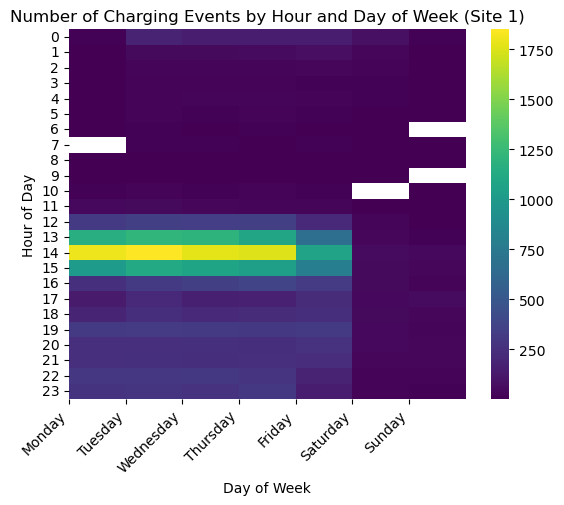

In [1550]:
## heatmap of charging sessions only for site=1

heatmap_data = df[df['siteID'] == 1].groupby(['hour', 'dayOfWeek']).size().unstack()
sns.heatmap(heatmap_data, cmap='viridis')
plt.title('Number of Charging Events by Hour and Day of Week (Site 1)')
plt.xlabel('Day of Week')
plt.ylabel('Hour of Day')
plt.xticks(range(0, 7), day_names.values(), rotation=45, ha='right')
plt.show()

A clear peak in activity is observed during weekday afternoons, particularly between 12:00  and 3:00 from Monday to Friday. Weekend usage is considerably lower. There are only minimal charging sessions recorded on Saturday and Sunday. This pattern suggests that Site 1 primarily serves weekday commuters or users with regular schedules. The high weekday activity and low weekend usage aligns with the charging habits of company employees, who typically follow a standard workweek.

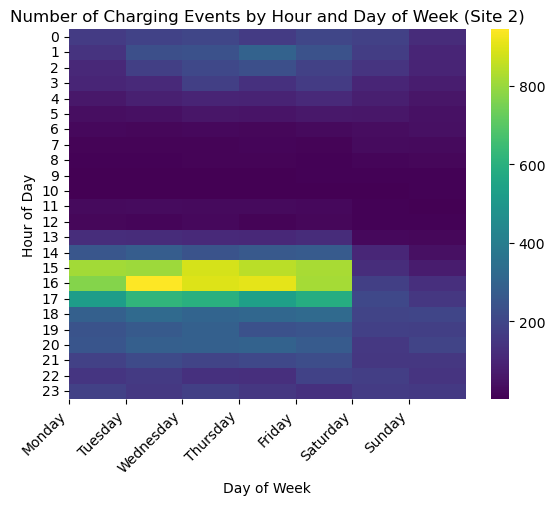

In [1551]:
## heatmap of charging events only for site=2

heatmap_data = df[df['siteID'] == 2].groupby(['hour', 'dayOfWeek']).size().unstack()
sns.heatmap(heatmap_data, cmap='viridis')
plt.title('Number of Charging Events by Hour and Day of Week (Site 2)')
plt.xlabel('Day of Week')
plt.ylabel('Hour of Day')
plt.xticks(range(0, 7), day_names.values(), rotation=45, ha='right')
plt.show()

The heatmap for Site 2 displays a slightly different charging pattern compared to Site 1. Similar to Site 1 the charging activity peaks on weekdays but the primary concentration is during the late afternoon and early evening hours, around 16:00  to 18:00. Weekend activity is also present but remains more consistent than at Site 1 with moderate activity levels on both Saturday and Sunday. 

This contrast indicates that Site 2 is a public site located at a university and likely attracts a more diverse group, including weekend travelers or users with varied charging behaviors.

##### Number of Charging Events by Day of Week

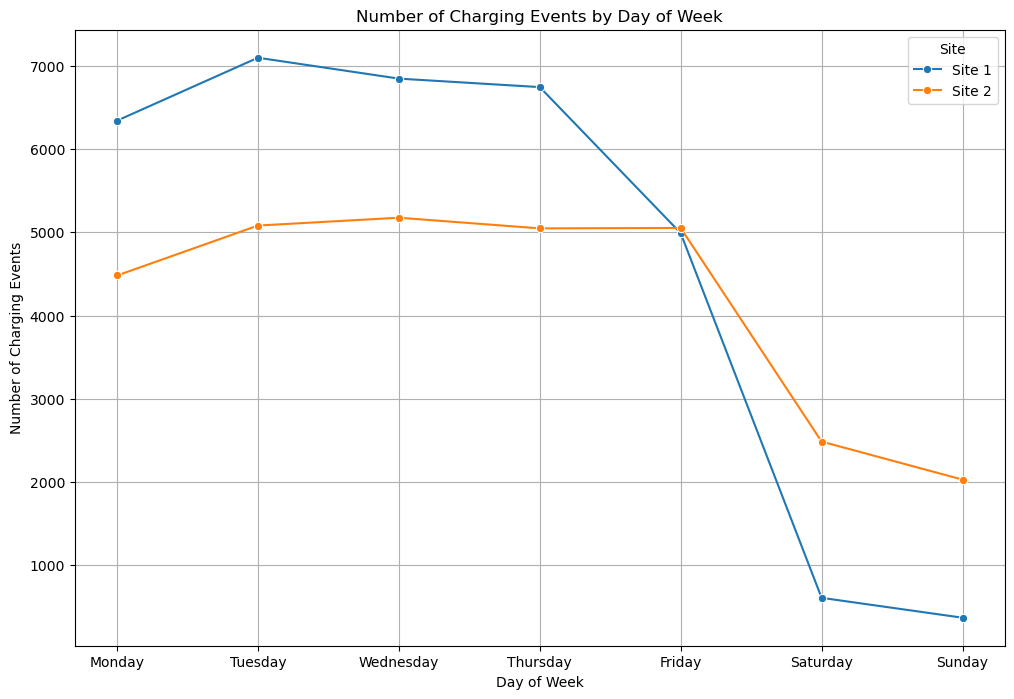

In [1552]:
## line diagram showing the number of charging sessions by day of week of site=1 and site=2 in one diagramm for comparison

side1_data = df[df['siteID'] == 1].groupby('dayOfWeek').size().reset_index(name='Charging Events')
side2_data = df[df['siteID'] == 2].groupby('dayOfWeek').size().reset_index(name='Charging Events')

plt.figure(figsize=(12, 8))
sns.lineplot(x='dayOfWeek', y='Charging Events', data=side1_data, label='Site 1', marker='o')
sns.lineplot(x='dayOfWeek', y='Charging Events', data=side2_data, label='Site 2', marker='o')
plt.title('Number of Charging Events by Day of Week')
plt.xlabel('Day of Week')
plt.ylabel('Number of Charging Events')
plt.xticks(range(0, 7), day_names.values())
plt.legend(title='Site')
plt.grid(True)
plt.show()

Site 1 consistently shows higher charging activity than Site 2 throughout the weekdays. During the weekend there is a significant drop. This suggests that site 1 primarily serves weekday users likely company employees with consistent work schedules. In contrast, Site 2 maintains a more stable trend during the weekdays.It also experiences a weaker decline during the weekend. This could potentially indicate that the university is situated in a location that attracts visitors for shopping or other activities. Therefore it leads to more consistent charging demand throughout the week.

##### Number of charging events by season (site 1 and site 2)

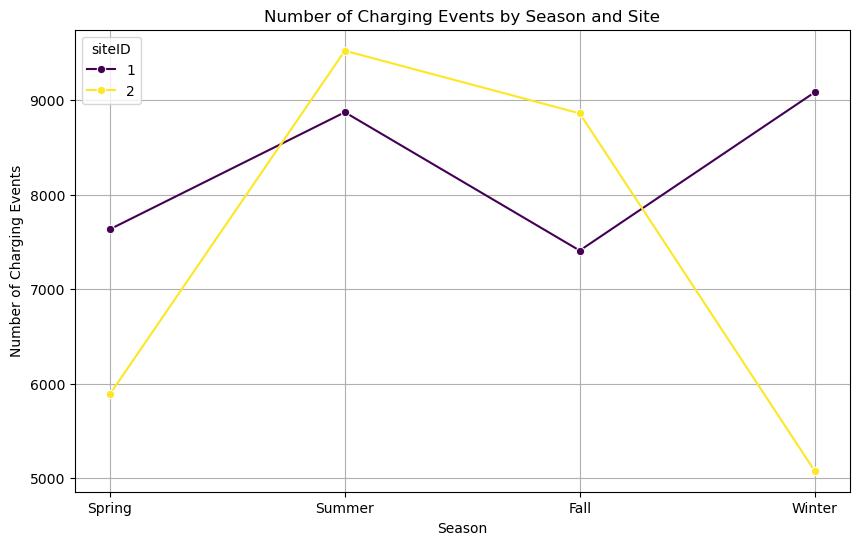

In [1553]:
# Plot the charging events from the two sites per season
# Group by site and season
site_seasonly_counts = df.groupby(['siteID', 'season']).size().reset_index(name='Charging Events')
site_seasonly_counts['season'] = pd.Categorical(site_seasonly_counts['season'], categories=season_order, ordered=True)
# Plot the charging events by season
plt.figure(figsize=(10, 6))
sns.lineplot(x='season', y='Charging Events', hue='siteID', data=site_seasonly_counts, palette='viridis', marker='o')
plt.title('Number of Charging Events by Season and Site')
plt.xlabel('Season')
plt.ylabel('Number of Charging Events')
plt.grid(True)
plt.show()

Seasonal patterns further differentiate the sites. Site 1 shows an overall increasing trend from spring to winter. It starts with moderate usage in spring, then peaks slightly during summer, dips in fall, and then rises again in winter. Here again the decline in fall could relate to employees going on vacation after the peak in summer where the working capacity was higher. After returning from vacations, employees return to work which is reflected in the increase from fall to winter.

Site 2 shows a peak in summer. This is followed by a significant decline in fall and reaching its lowest point in winter. Reduced activity in fall and winter could be caused by seasonal holidays and the end of the summer semester. Therefore site 2 aligns with the characteristics of a public charging hub, such as one located at a university, where demand fluctuates based on the academic calendar.

The analysis of the two sites based on temporal and seasonal trends, combined with heatmaps and graphs, strongly supports the hypothesis that Site 1 operates as a private charging site for a company while Site 2 functions as a public charging hub likely at a university. The clear differences in weekday-weekend splits, monthly trends tied to academic or business cycles and heatmap patterns reveal the underlying user behaviors of the two sites.

# Clustering

To identify groups of archetypical charging events we apply clustering. We select the features 'charging_duration', 'session_duration', 'idleTime', and 'kWhDelivered', since these are the numerical data that describe the charging process

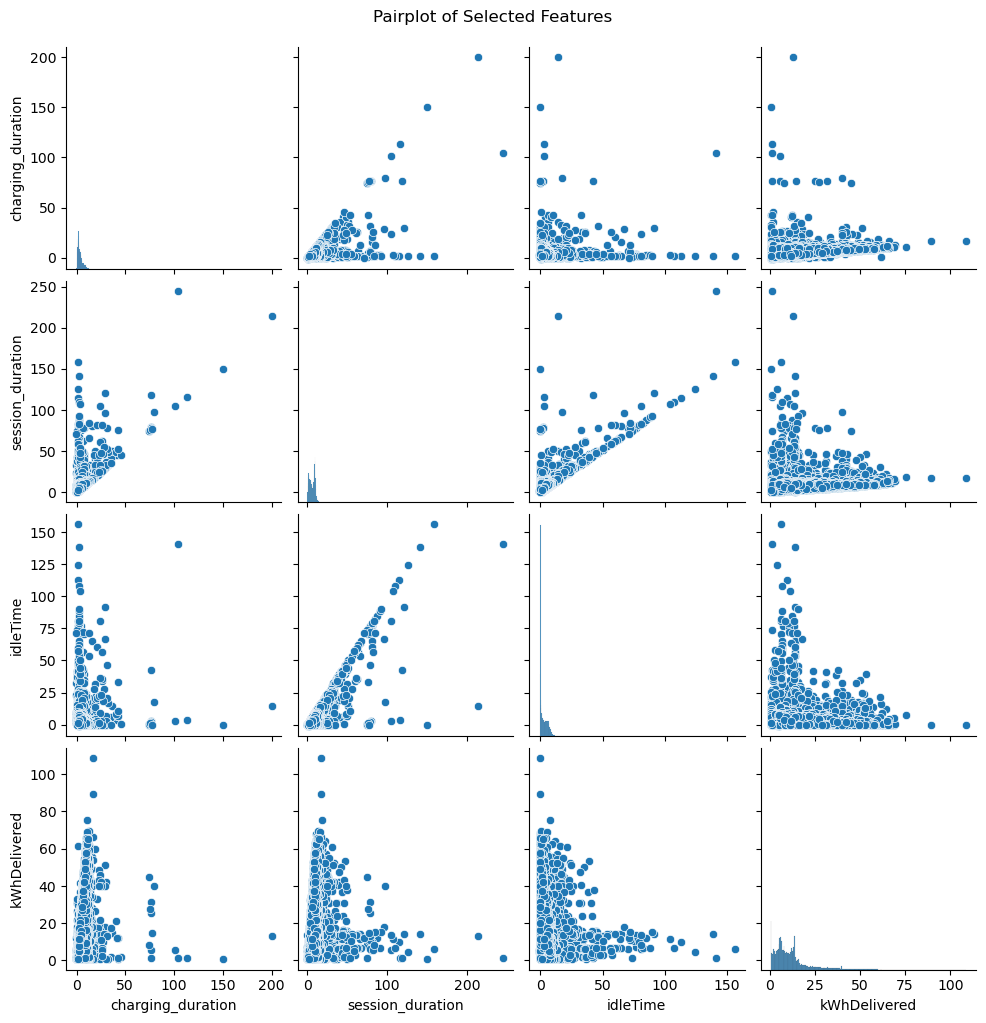

In [1554]:
df["idleTime"] = (df["disconnectTime"] - df["doneChargingTime"]).dt.total_seconds() / 3600

features = ['charging_duration', 'session_duration', 'idleTime', 'kWhDelivered']
df_numerical = df[features]

sns.pairplot(df_numerical)
plt.suptitle('Pairplot of Selected Features', y=1.02)
plt.show()

As observed in the pairplot, the dataset contains outliers that could negatively impact the clustering process. To address this we, identify and remove outliers using the 3 sigma threshold

Check for sus. low/high nubmer values

In [1555]:
numeric = df.select_dtypes(include=[np.number])
stats = numeric.where(numeric != -1).agg(['min', 'max']).T
# Print the results
for col, row in stats.iterrows():
    print(f"Column '{col}': min={row['min']}, max={row['max']}")


Column 'kWhDelivered': min=0.501, max=108.79724166666666
Column 'siteID': min=1.0, max=2.0
Column 'WhPerMile': min=50.0, max=2000.0
Column 'kWhRequested': min=0.0, max=215.32
Column 'milesRequested': min=0.0, max=480.0
Column 'minutesAvailable': min=1.0, max=10062.0
Column 'isRegisteredUser': min=0.0, max=1.0
Column 'charging_duration': min=-0.6894444444444444, max=200.01583333333335
Column 'session_duration': min=0.050833333333333335, max=245.26916666666668
Column 'year': min=2018.0, max=2021.0
Column 'month': min=1.0, max=12.0
Column 'dayOfWeek': min=0.0, max=6.0
Column 'hour': min=0.0, max=23.0
Column 'hourDisconnected': min=0.0, max=23.0
Column 'Month': min=1.0, max=12.0
Column 'idleTime': min=-0.9988888888888889, max=156.1213888888889


In [1556]:
# Calculate mean and standard deviation for each feature
mean = df_numerical.mean()
std = df_numerical.std()

# Define the 3-sigma range
lower_bound = mean - 3 * std
upper_bound = mean + 3 * std

# Filter out points that fall outside the 3-sigma range
df_clustering = df_numerical[
    (df_numerical >= lower_bound) & (df_numerical <= upper_bound)
].dropna()

print(f'Original number of points: {len(df_numerical)}')
print(f'Number of points after 3-sigma filtering: {len(df_clustering)}')

Original number of points: 62362
Number of points after 3-sigma filtering: 60435


We decided to implement soft clustering due to the significant overlap in the data, as hard clustering was not appropriate for this scenario. Hard clustering methods, such as K-Means, assign each data point to a single cluster, which can lead to inaccurate results when clusters overlap. In contrast, we chose the Gaussian Mixture Model (GMM) because it provides probabilistic cluster assignments, allowing data points to belong to multiple clusters with varying probabilities

To ensure that all features contribute equally to the clustering process, we scale the data before fitting the model. We then determine the optimal number of clusters by evaluating different model configurations using the Bayesian Information Criterion (BIC). This score penalizes the addition of extra parameters to avoid overfitting.

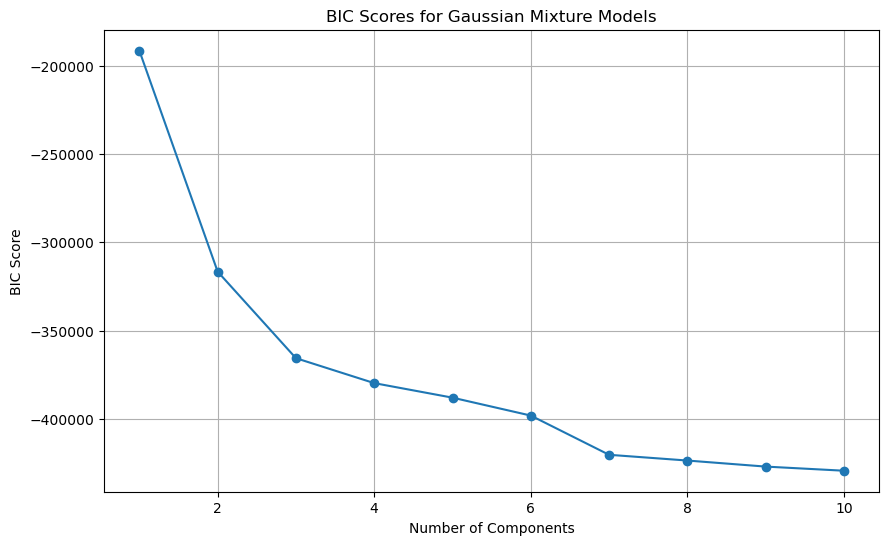

In [1557]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(df_clustering)

# Determine the optimal number of clusters using BIC
bic_scores = []
n_components_range = range(1, 11)
for n_components in n_components_range:
    gmm = GaussianMixture(n_components=n_components, random_state=42)
    gmm.fit(X_scaled)
    bic_scores.append(gmm.bic(X_scaled))

plt.figure(figsize=(10, 6))
plt.plot(n_components_range, bic_scores, marker='o')
plt.title('BIC Scores for Gaussian Mixture Models')
plt.xlabel('Number of Components')
plt.ylabel('BIC Score')
plt.grid(True)
plt.show()

The elbow method suggests choosing 3 clusters, as the model fit improves significantly slower from that point on.

In [1558]:
# Fit the GMM with the optimal number of cluters
optimal_components = 3
best_gmm = GaussianMixture(n_components=optimal_components, random_state=42)
best_gmm.fit(X_scaled)
df_clustering['cluster'] = best_gmm.predict(X_scaled)

In [ ]:
# Add cluster labels to the original dataset
df['cluster'] = -1  # Default cluster for rows dropped due to NaN
if len(df_clustering) > 0:
    df.loc[df_clustering.index, 'cluster'] = df_clustering['cluster']

# Visualize the clusters using pairplot
plt.figure(figsize=(12, 10))
sns.pairplot(df_clustering.assign(cluster=df_clustering['cluster'].astype(str)), 
             vars=features, hue='cluster', palette='muted', diag_kind='kde')
plt.suptitle('Gaussian Mixture Model Clustering', y=1.02)
plt.show()

# Generate descriptive statistics for each cluster
cluster_summary = df_clustering.groupby('cluster')[features].mean()
print("Cluster Summary: mean of features")
print(cluster_summary)


<Figure size 1200x1000 with 0 Axes>

## Names for clusters


Cluster 1 (Blue): Extended Stay
- Longer charging sessions with significant idle time

Cluster 2 (Orange): Slow Overnight Charge
- Long charging durations with low kWh delivery, which suggests charging over night

Cluster 3 (Green): Fast Charging Peak
- Short charging sessions with high kWh delivered, and short idle time

By identifying the different types of charging operations, the operator can gain valuable insights that can help them make decisions. This could improve resource allocation and load management. Fast charging peaks may require more energy capacity, while night-time charging may be less demanding. Charging networks can use this data to optimize grid management and ensure that sufficient energy is available at peak times. 

# Prediction

Create a dataset with daily utilization from the past

In [1487]:

df_site_1 = df[df['siteID'] == 1]
df_site_2 = df[df['siteID'] == 2]

def create_df_prediction(df_site):
    date_range = pd.date_range(start=df_site['connectionTime'].min().date(), end=df_site['connectionTime'].max().date(), freq='D')

    df_prediction = pd.DataFrame([(date, hour) for date in date_range for hour in range(24)], columns=['date', 'hour'])
    df_prediction = df_prediction[
        (df_prediction['date'] < '2020-08-04') | (df_prediction['date'] > '2020-11-17')
    ]
    df_prediction['datetime'] = pd.to_datetime(df_prediction['date'].astype(str) + ' ' + df_prediction['hour'].astype(str) + ':00:00')
    df_prediction['date'] = pd.to_datetime(df_prediction['date'])
    df_prediction['weekday'] = df_prediction['date'].dt.dayofweek
    df_prediction['month'] = df_prediction['date'].dt.month
    df_prediction.set_index('datetime', inplace=True)
    
    utilization_rates = []
    for unique_day in df_prediction['date'].unique():
        hourly_utilization_rate = calculate_utilization_rate_hourly(df_site, unique_day)  
        utilization_rates.extend(hourly_utilization_rate)

    df_prediction['utilization'] = utilization_rates
    return df_prediction

df_prediction_1 = create_df_prediction(df_site_1)
df_prediction_2 = create_df_prediction(df_site_2)

We add isPublicHoliday as a feature

In [1488]:
# We add public holiday as a feature
holidays = [
    # 2018
    {"date": "2018-01-01", "name": "Neujahr"},
    {"date": "2018-01-15", "name": "Martin Luther King Jr. Day"},
    {"date": "2018-02-19", "name": "President's Day"},
    {"date": "2018-03-31", "name": "César Chávez Day"},
    {"date": "2018-05-28", "name": "Memorial Day"},
    {"date": "2018-07-04", "name": "Independence Day"},
    {"date": "2018-09-03", "name": "Labor Day"},
    {"date": "2018-11-11", "name": "Veterans Day"},
    {"date": "2018-11-22", "name": "Thanksgiving"},
    {"date": "2018-12-25", "name": "Weihnachten"},

    # 2019
    {"date": "2019-01-01", "name": "Neujahr"},
    {"date": "2019-01-21", "name": "Martin Luther King Jr. Day"},
    {"date": "2019-02-18", "name": "President's Day"},
    {"date": "2019-03-31", "name": "César Chávez Day"},
    {"date": "2019-05-27", "name": "Memorial Day"},
    {"date": "2019-07-04", "name": "Independence Day"},
    {"date": "2019-09-02", "name": "Labor Day"},
    {"date": "2019-11-11", "name": "Veterans Day"},
    {"date": "2019-11-28", "name": "Thanksgiving"},
    {"date": "2019-12-25", "name": "Weihnachten"},

    # 2020
    {"date": "2020-01-01", "name": "Neujahr"},
    {"date": "2020-01-20", "name": "Martin Luther King Jr. Day"},
    {"date": "2020-02-17", "name": "President's Day"},
    {"date": "2020-03-31", "name": "César Chávez Day"},
    {"date": "2020-05-25", "name": "Memorial Day"},
    {"date": "2020-07-04", "name": "Independence Day"},
    {"date": "2020-09-07", "name": "Labor Day"},
    {"date": "2020-11-11", "name": "Veterans Day"},
    {"date": "2020-11-26", "name": "Thanksgiving"},
    {"date": "2020-12-25", "name": "Weihnachten"},

    # 2021
    {"date": "2021-01-01", "name": "Neujahr"},
    {"date": "2021-01-18", "name": "Martin Luther King Jr. Day"},
    {"date": "2021-02-15", "name": "President's Day"},
    {"date": "2021-03-31", "name": "César Chávez Day"},
    {"date": "2021-05-31", "name": "Memorial Day"},
    {"date": "2021-07-04", "name": "Independence Day"},
    {"date": "2021-09-06", "name": "Labor Day"},
    {"date": "2021-11-11", "name": "Veterans Day"},
    {"date": "2021-11-25", "name": "Thanksgiving"},
    {"date": "2021-12-25", "name": "Weihnachten"},

    # 2022
    {"date": "2022-01-01", "name": "Neujahr"},
    {"date": "2022-01-17", "name": "Martin Luther King Jr. Day"},
    {"date": "2022-02-21", "name": "President's Day"},
    {"date": "2022-03-31", "name": "César Chávez Day"},
    {"date": "2022-05-30", "name": "Memorial Day"},
    {"date": "2022-07-04", "name": "Independence Day"},
    {"date": "2022-09-05", "name": "Labor Day"},
    {"date": "2022-11-11", "name": "Veterans Day"},
    {"date": "2022-11-24", "name": "Thanksgiving"},
    {"date": "2022-12-25", "name": "Weihnachten"}
]


In [1489]:
holiday_dates = set(pd.to_datetime([holiday['date'] for holiday in holidays]))


### Import the weather dataset to get more features


In [ ]:
df_weather = pd.read_csv("./Data/weather_burbank_airport.csv")
df_weather.drop(columns=['city', 'cloud_cover', 'cloud_cover_description', 'pressure', 'felt_temperature'], inplace=True)
df_weather["date"] = pd.to_datetime(df_weather['timestamp']).dt.date
df_weather["hour"] = pd.to_datetime(df_weather['timestamp']).dt.hour
df_weather.drop(columns=['timestamp'], inplace=True)
df_weather['date'] = pd.to_datetime(df_weather['date'])  # Ensure datetime64[ns] in df_weather

# merge for each site-specific 
for i, df_prediction in enumerate([df_prediction_1, df_prediction_2]):
    df_prediction['date'] = pd.to_datetime(df_prediction['date'])  # Ensure datetime64[ns] in df_prediction
    merged_df = pd.merge(df_prediction, df_weather, how='left', on=['date', 'hour'])

    # Update (df_prediction_1 or df_prediction_2)
    if i == 0:
        df_prediction_1

# Merge weather data with each site-specific df_prediction
for i, df_prediction in enumerate([df_prediction_1, df_prediction_2]):
    df_prediction['date'] = pd.to_datetime(df_prediction['date'])
    merged_df = pd.merge(df_prediction, df_weather, how='left', on=['date', 'hour'])
    
    if i == 0:
        df_prediction_1 = merged_df
    elif i == 1:
        df_prediction_2 = merged_df
df_prediction['isPublicHoliday'] = df_prediction['date'].apply(lambda x: 1 if x in holiday_dates else 0)
df_prediction.isna().sum()



date               0
hour               0
weekday            0
month              0
utilization        0
isPublicHoliday    0
dtype: int64

For the features temperature, windspeed, and precipitation, we have several missing values. Since these weather data are hourly, the best suited interpolation strategy would be applying a foreward fill

In [1491]:
for df_prediction in [df_prediction_1, df_prediction_2]:
    df_prediction['temperature'] = df_prediction['temperature'].ffill().fillna(0)
    df_prediction['windspeed'] = df_prediction['windspeed'].ffill().fillna(0)
    df_prediction['precipitation'] = df_prediction['precipitation'].ffill().fillna(0)

## Find most important features for models

In [1492]:
print(df['day'].dtype)
print(df_weather['date'].dtype)

df['day'] = pd.to_datetime(df['day'])
df_weather['date'] = pd.to_datetime(df_weather['date'])
print(df['day'].dtype)
print(df_weather['date'].dtype)

object
datetime64[ns]
datetime64[ns]
datetime64[ns]


In [ ]:

df['session_duration'] = (df['disconnectTime'] - df['connectionTime']).dt.total_seconds() / 3600
df['utilization_rate'] = (df['session_duration'] / 24) * 100
df['hour'] = df['connectionTime'].dt.hour
df['day_of_week'] = df['connectionTime'].dt.dayofweek
df['is_weekend'] = df['day_of_week'].isin([5, 6]).astype(int)
# print(df.head())
df_merged = pd.merge(df, df_weather, how='left', left_on='day', right_on='date')

print(df_weather.columns)


X_full = df_merged[['siteID', 'hour_x', 'hour_y', 'day_of_week', 'month', 'year', 
             'session_duration', 'is_weekend', 'temperature', 'windspeed', 'precipitation']]
y_full = df_merged['utilization_rate']  
X_train, X_test, y_train, y_test = train_test_split(X_full, y_full, test_size=0.2, random_state=42)

preprocessor = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(handle_unknown='ignore'), ['siteID', 'day_of_week', 'month'])
    ],
    remainder='passthrough'
)

pipeline_dt = Pipeline([
    ('preprocessor', preprocessor),
    ('model', DecisionTreeRegressor(max_depth=8, random_state=42))  # Limit depth to avoid huge trees
])

pipeline_dt.fit(X_train, y_train)

y_pred_train = pipeline_dt.predict(X_train)
y_pred_test = pipeline_dt.predict(X_test)

# Rank Feature importance
feature_importances = pd.Series(
    pipeline_dt.named_steps['model'].feature_importances_,
    index=pipeline_dt.named_steps['preprocessor'].get_feature_names_out()
).sort_values(ascending=False)

print(feature_importances)



Index(['temperature', 'windspeed', 'precipitation', 'date', 'hour'], dtype='object')
remainder__session_duration    9.994553e-01
cat__month_3                   3.204554e-04
remainder__hour_x              1.886389e-04
cat__month_8                   2.013145e-05
cat__month_11                  1.071225e-05
cat__day_of_week_3             4.027519e-06
cat__day_of_week_4             7.098169e-07
remainder__hour_y              8.243675e-17
remainder__precipitation       3.557675e-17
remainder__windspeed           0.000000e+00
remainder__temperature         0.000000e+00
remainder__is_weekend          0.000000e+00
remainder__year                0.000000e+00
cat__month_12                  0.000000e+00
cat__month_10                  0.000000e+00
cat__month_9                   0.000000e+00
cat__siteID_1                  0.000000e+00
cat__month_7                   0.000000e+00
cat__siteID_2                  0.000000e+00
cat__month_5                   0.000000e+00
cat__month_4                   0.00

It turns out, that the most important features for utilisation rate are hour, day, month, precipitation. Therefore these are the only ones we need to include in the final models

Define the variables that we want to use for regression

In [1494]:
X_1 = df_prediction_1[['hour', 'weekday', 'month', 'temperature', 'precipitation']]
y_1 = df_prediction_1['utilization']

X_2 = df_prediction_2[['hour', 'weekday', 'month', 'temperature', 'precipitation']]
y_2 = df_prediction_2['utilization']

X_train_1, X_test_1, y_train_1, y_test_1 = train_test_split(X_1, y_1, test_size=0.2, random_state=42)
# X_val_1, X_test_1, y_val_1, y_test_1 = train_test_split(X_temp_1, y_temp_1, test_size=0.3333, random_state=42)

X_train_2, X_test_2, y_train_2, y_test_2 = train_test_split(X_2, y_2, test_size=0.2, random_state=42)
# X_val_2, X_test_2, y_val_2, y_test_2 = train_test_split(X_temp_2, y_temp_2, test_size=0.3333, random_state=42)


We choose the degree of polynomial of 4, since the MSE decreases for both training and testing sets to that degree before increasing again. To ensure that the choice of the hyperparameter d was correct, we evaluate the performance of the model on the validation set

## X-Boost

In [ ]:
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

# Train models for both sites
def train_xgboost(X_train, y_train):
    model = XGBRegressor(
        n_estimators=400,
        learning_rate=0.01,
        max_depth=10,
        subsample=0.6,
        colsample_bytree=0.8,
        random_state=42
    )
    model.fit(X_train, y_train)
    
    y_train_pred = model.predict(X_train)

    print("Performance on training data:")
    print(f"Training - MSE: {mean_squared_error(y_train, y_train_pred):.2f}, "
          f"R²: {r2_score(y_train, y_train_pred):.2f}, "
          f"MAE: {mean_absolute_error(y_train, y_train_pred):.2f}")
    return model

print("Training Model for Site 1:")
model_1 = train_xgboost(X_train_1, y_train_1)

print("\nTraining Model for Site 2:")
model_2 = train_xgboost(X_train_2, y_train_2)

# Test performance on test data Site 1
y_test_pred_1 = model_1.predict(X_test_1)
print("\nTest Performance on test data for Site 1:")
print(f"MSE: {mean_squared_error(y_test_1, y_test_pred_1):.2f}, "
      f"R²: {r2_score(y_test_1, y_test_pred_1):.2f}, "
      f"MAE: {mean_absolute_error(y_test_1, y_test_pred_1):.2f}")

# Test performance on test Site 2
y_test_pred_2 = model_2.predict(X_test_2)
print("\nTest Performance on test data for Site 2:")
print(f"MSE: {mean_squared_error(y_test_2, y_test_pred_2):.2f}, "
      f"R²: {r2_score(y_test_2, y_test_pred_2):.2f}, "
      f"MAE: {mean_absolute_error(y_test_2, y_test_pred_2):.2f}")

Training Model for Site 1:
Performance on training data:
Training - MSE: 89.62, R²: 0.75, MAE: 4.65

Training Model for Site 2:
Performance on training data:
Training - MSE: 21.81, R²: 0.61, MAE: 2.95

Test Performance on test data for Site 1:
MSE: 104.91, R²: 0.69, MAE: 4.99

Test Performance on test data for Site 2:
MSE: 27.02, R²: 0.49, MAE: 3.34


Training Model for Site 1:


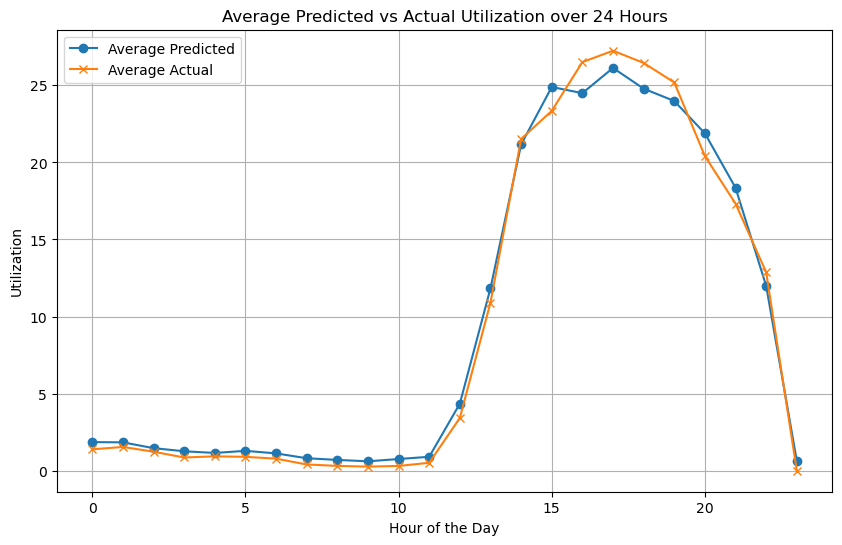


Training Model for Site 2:


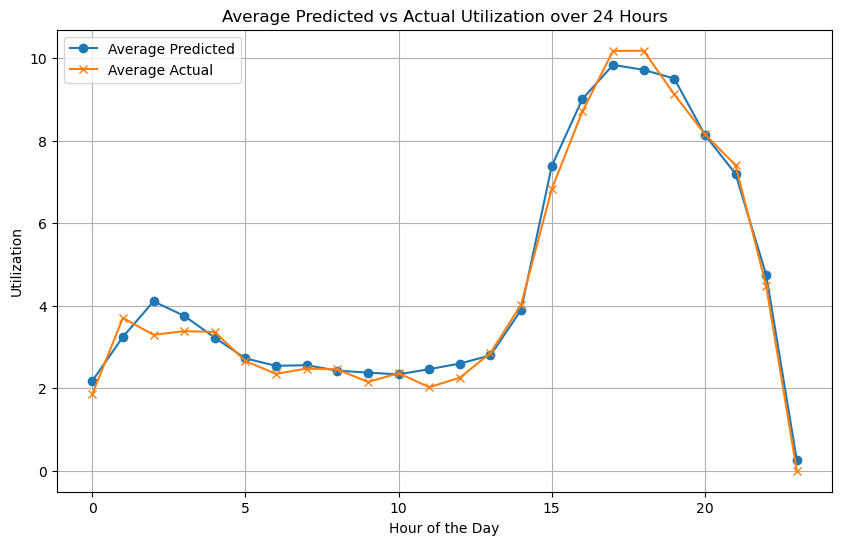


Test Performance on test data for Site 1:
MSE: 104.91, R²: 0.69, MAE: 4.99

Test Performance on test data for Site 2:
MSE: 27.02, R²: 0.49, MAE: 3.34


In [ ]:
import graphviz
from sklearn.tree import DecisionTreeRegressor, export_graphviz
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.model_selection import GridSearchCV
# Function to train Decision Tree with Grid Search
def train_decision_tree_with_grid_search(X_train, y_train):
    param_grid = {
        'max_depth': [4, 6, 8],               
        'min_samples_split': [5, 10, 20],    
        'min_samples_leaf': [2, 4, 8],      
        'ccp_alpha': [0.05, 0.1, 0.5]   # CC parameter
    }
    
    model = DecisionTreeRegressor(random_state=42)
    
    grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=3, 
                               n_jobs=-1, scoring='neg_mean_squared_error')
    grid_search.fit(X_train, y_train)
    
    # Best Model
    best_model = grid_search.best_estimator_
    y_train_pred = best_model.predict(X_train)
    
    print("Best Hyperparameters:", grid_search.best_params_)
    print(f"Tree Depth: {best_model.get_depth()}")
    print(f"Number of Leaves: {best_model.get_n_leaves()}")
    print("Performance on training data:")
    print(f"Training - MSE: {mean_squared_error(y_train, y_train_pred):.2f}, "
          f"R²: {r2_score(y_train, y_train_pred):.2f}, "
          f"MAE: {mean_absolute_error(y_train, y_train_pred):.2f}")
    dot_data = export_graphviz(best_model, out_file=None, feature_names=X_train.columns.tolist(),
                               filled=True, rounded=True, special_characters=True)
    graph = graphviz.Source(dot_data)
    graph.format = 'png'
    graph.render("decision_tree")  # Saves the tree as 'decision_tree.png'
    print("High-resolution tree saved as 'decision_tree.png'")
    
    return best_model


def plot_average_predicted_utilization(model, X_test, y_test, feature_name):
    y_pred = model.predict(X_test)

    hours = X_test[feature_name]

    results_df = pd.DataFrame({
        'hour': hours,
        'predicted': y_pred,
        'actual': y_test
    })

    avg_results = results_df.groupby('hour').mean()

    plt.figure(figsize=(10, 6))
    plt.plot(avg_results.index, avg_results['predicted'], label="Average Predicted", marker='o')
    plt.plot(avg_results.index, avg_results['actual'], label="Average Actual", marker='x')
    plt.title("Average Predicted vs Actual Utilization over 24 Hours")
    plt.xlabel("Hour of the Day")
    plt.ylabel("Utilization")
    plt.legend()
    plt.grid(True)
    plt.show()


print("Training Model for Site 1:")
plot_average_predicted_utilization(model_1, X_test_1, y_test_1, feature_name="hour")

print("\nTraining Model for Site 2:")
plot_average_predicted_utilization(model_2, X_test_2, y_test_2, feature_name="hour")

y_test_pred_1 = model_1.predict(X_test_1)
print("\nTest Performance on test data for Site 1:")
print(f"MSE: {mean_squared_error(y_test_1, y_test_pred_1):.2f}, "
      f"R²: {r2_score(y_test_1, y_test_pred_1):.2f}, "
      f"MAE: {mean_absolute_error(y_test_1, y_test_pred_1):.2f}")

y_test_pred_2 = model_2.predict(X_test_2)
print("\nTest Performance on test data for Site 2:")
print(f"MSE: {mean_squared_error(y_test_2, y_test_pred_2):.2f}, "
      f"R²: {r2_score(y_test_2, y_test_pred_2):.2f}, "
      f"MAE: {mean_absolute_error(y_test_2, y_test_pred_2):.2f}")



## Neural Network

In [ ]:
# Standardize features
scaler_1 = StandardScaler()

X_train_1_scaled = pd.DataFrame(scaler_1.fit_transform(X_train_1), columns=X_train_1.columns)
X_test_1_scaled = pd.DataFrame(scaler_1.transform(X_test_1), columns=X_test_1.columns)

scaler_2 = StandardScaler()
X_train_2_scaled = pd.DataFrame(scaler_2.fit_transform(X_train_2), columns=X_train_2.columns)
X_test_2_scaled = pd.DataFrame(scaler_2.transform(X_test_2), columns=X_test_2.columns)

# Function to train the MLPRegressor model
def train_mlp(X_train, y_train):
    # Initialize the model
    model = MLPRegressor(
        hidden_layer_sizes=(100, 50),  # Two hidden layers with 100 and 50 neurons
        activation='relu',            # ReLU activation function
        solver='adam',                # Optimization algorithm
        learning_rate_init=0.01,      # Initial learning rate
        max_iter=500,                 # Maximum number of iterations
        random_state=42               # Seed for reproducibility
    )
    # Train the model
    model.fit(X_train, y_train)

# Predict on training set
    y_train_pred = model.predict(X_train)

    # Evaluate performance
    print("Performance:")
    print(f"Training - MSE: {mean_squared_error(y_train, y_train_pred):.2f}, "
          f"R²: {r2_score(y_train, y_train_pred):.2f}, "
          f"MAE: {mean_absolute_error(y_train, y_train_pred):.2f}")
    
    return model

# Train the model for site 1
print("Training NN Model for Site 1:")
model_nn_1 = train_mlp(X_train_1_scaled, y_train_1)

# Train the model for site 2
print("\nTraining NN Model for Site 2:")
model_nn_2 = train_mlp(X_train_2_scaled, y_train_2)

# Test performance for site 1
y_test_pred_nn_1 = model_nn_1.predict(X_test_1_scaled)
print("\nTest Performance for NN Model - Site 1:")
print(f"MSE: {mean_squared_error(y_test_1, y_test_pred_nn_1):.2f}, "
      f"R²: {r2_score(y_test_1, y_test_pred_nn_1):.2f}, "
      f"MAE: {mean_absolute_error(y_test_1, y_test_pred_nn_1):.2f}")

# Test performance for site 2
y_test_pred_nn_2 = model_nn_2.predict(X_test_2_scaled)
print("\nTest Performance for NN Model - Site 2:")
print(f"MSE: {mean_squared_error(y_test_2, y_test_pred_nn_2):.2f}, "
      f"R²: {r2_score(y_test_2, y_test_pred_nn_2):.2f}, "
      f"MAE: {mean_absolute_error(y_test_2, y_test_pred_nn_2):.2f}")


Training NN Model for Site 1:
Performance:
Training - MSE: 92.54, R²: 0.74, MAE: 4.69

Training NN Model for Site 2:
Performance:
Training - MSE: 26.27, R²: 0.53, MAE: 3.42

Test Performance for NN Model - Site 1:
MSE: 105.59, R²: 0.69, MAE: 4.91

Test Performance for NN Model - Site 2:
MSE: 28.66, R²: 0.46, MAE: 3.56


Training NN Model for Site 1 with Randomized Search:
Best Hyperparameters: {'learning_rate_init': 0.0005623413251903491, 'hidden_layer_sizes': (100, 50), 'alpha': 0.001}
Performance on training data:
Training - MSE: 113.21, R²: 0.69, MAE: 5.45

Training NN Model for Site 2 with Randomized Search:
Best Hyperparameters: {'learning_rate_init': 0.001, 'hidden_layer_sizes': (50, 50), 'alpha': 0.00031622776601683794}
Performance on training data:
Training - MSE: 28.42, R²: 0.49, MAE: 3.50

Test Performance for NN Model - Site 1:
MSE: 112.60, R²: 0.67, MAE: 5.38

Test Performance for NN Model - Site 2:
MSE: 29.09, R²: 0.45, MAE: 3.56

Plotting results for Site 1:


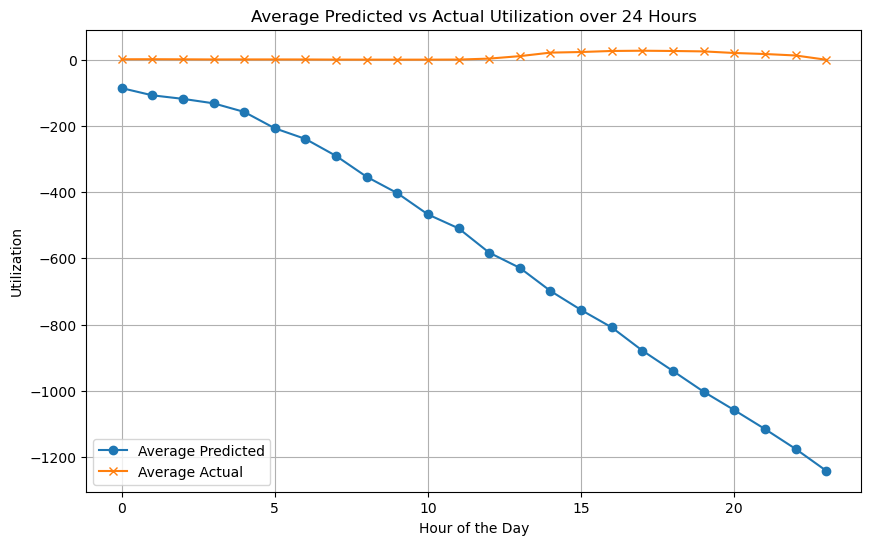


Plotting results for Site 2:


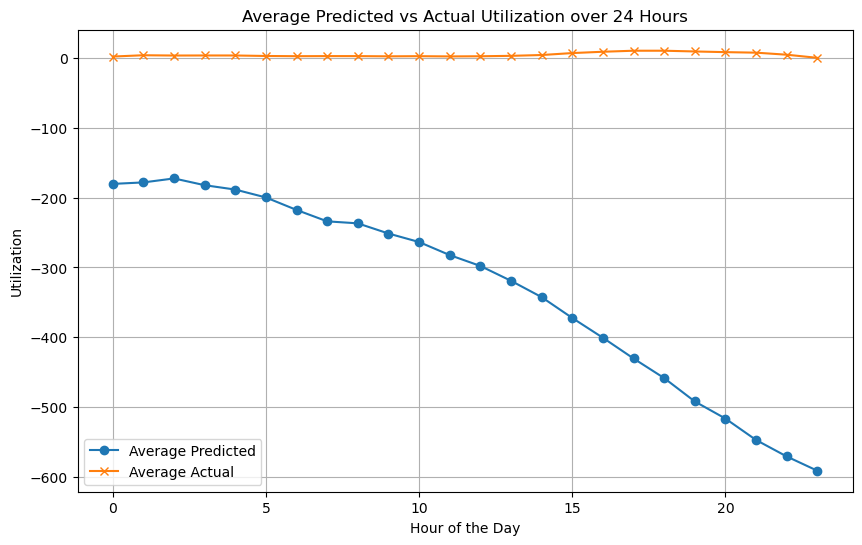

In [1498]:
# Function to train MLPRegressor with Randomized Search
def train_mlp_with_random_search(X_train, y_train):
    param_dist = {
        'hidden_layer_sizes': [(50,), (100,), (100, 50), (50, 50)],  # Different architectures
        'learning_rate_init': np.logspace(-4, -3, 5),               # Log-spaced learning rates
        'alpha': np.logspace(-4, -2, 5)                              # Log-spaced regularization strengths
    }
    
    model = MLPRegressor(activation='relu', batch_size='auto', solver='adam', max_iter=2000, random_state=42, early_stopping=True)

    random_search = RandomizedSearchCV(estimator=model, param_distributions=param_dist, 
                                       n_iter=10, cv=3, n_jobs=-1, scoring='neg_mean_squared_error', random_state=42)
    random_search.fit(X_train, y_train)
    
    # Best Model
    best_model = random_search.best_estimator_
    y_train_pred = best_model.predict(X_train)
    
    print("Best Hyperparameters:", random_search.best_params_)
    print("Performance on training data:")
    print(f"Training - MSE: {mean_squared_error(y_train, y_train_pred):.2f}, "
          f"R²: {r2_score(y_train, y_train_pred):.2f}, "
          f"MAE: {mean_absolute_error(y_train, y_train_pred):.2f}")
    
    return best_model

# Train the model for site 1
print("Training NN Model for Site 1 with Randomized Search:")
model_nn_1 = train_mlp_with_random_search(X_train_1_scaled, y_train_1)

# Train the model for site 2
print("\nTraining NN Model for Site 2 with Randomized Search:")
model_nn_2 = train_mlp_with_random_search(X_train_2_scaled, y_train_2)

# Test performance for site 1
y_test_pred_nn_1 = model_nn_1.predict(X_test_1_scaled)
print("\nTest Performance for NN Model - Site 1:")
print(f"MSE: {mean_squared_error(y_test_1, y_test_pred_nn_1):.2f}, "
      f"R²: {r2_score(y_test_1, y_test_pred_nn_1):.2f}, "
      f"MAE: {mean_absolute_error(y_test_1, y_test_pred_nn_1):.2f}")

# Test performance for site 2
y_test_pred_nn_2 = model_nn_2.predict(X_test_2_scaled)
print("\nTest Performance for NN Model - Site 2:")
print(f"MSE: {mean_squared_error(y_test_2, y_test_pred_nn_2):.2f}, "
      f"R²: {r2_score(y_test_2, y_test_pred_nn_2):.2f}, "
      f"MAE: {mean_absolute_error(y_test_2, y_test_pred_nn_2):.2f}")

# Plot results for site 1
print("\nPlotting results for Site 1:")
plot_average_predicted_utilization(model_nn_1, X_test_1, y_test_1, feature_name="hour")

# Plot results for site 2
print("\nPlotting results for Site 2:")
plot_average_predicted_utilization(model_nn_2, X_test_2, y_test_2, feature_name="hour")


## Performance notes: 
-Evaluated: x-boost, ada boost, bagging, gradient boosting/random forest, decision tree
-X-boost best performance: r2 of 0.45


# 2Dos
-	Restructuring:
o	Create structure where we do datacleaning in the beginning (DONE)
-	Data cleaning:
o	Add isRegistered as variable and drop UserID (DONE)
o	Check for all numerical values for min and max, do outlier detection based on these (DONE)
o	Check for different timezones within the data (e.g. everything utc?) (DONE)
-	Business understanding:
o	Impact of user inputs of sessions?
-	Task 2a):
o	Find possible correlation between charging behavior and weather – (rain, temperature)
o	Compare charging events from two sites (number of charging events per year, month, season) (site 1 and 2)
o	According to janik, bar charts are not enough at this task. more detail 
-	Task 2c):
o	Missing reasons which site is which
-	Clustering: 
o   Also take time related data into consideration. For transformation a mix of sin/cos function should work (according to janik)
o	take kWhRequested, minutesAvailable, paymentRequired, milesRequested into clustering! 
o	Data cleaning for clustering: because of 16000 new values we have a lot of nan values for variables that we want to consider. These need to be handled 
o	There might be new clusters!
-	Prediction:
o	Test with new data (Done)
o	Maybe consider to add a new feature to the dataset for the public station for the university: officialUniversityHoliday; and check if it has impact (DONE)
o	Prune tree (for tree model) (Done)
o   New validation methods. Write text regarding performance (Done)
o   Check if xboost modle is explainable (DONE, is not, replaced with normal tree)
-	other:
o	check for covid assumption (for the time where no data are available)